
# 导入包

In [1]:
#  基础数据科学运算库
import pandas as pd
import numpy as np
import math
from scipy import stats

# 可视化库
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman') 
# 排列组合函数
from itertools import product 
# 时间模块
import time
# sklearn库
# 数据预处理
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_predict,cross_validate,cross_val_score,KFold,LeaveOneOut
from sklearn import metrics
# 常用评估器
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

# 常用的特征选择方法
import pymrmr
from minepy import MINE
import shap
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import dcor

#忽略警告
import warnings
warnings.filterwarnings('ignore')


D:\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 导入数据

In [2]:
data_hea=pd.read_csv('HEA_data.csv')# github上数据名：HEAs.csv
data_hea=data_hea.iloc[:,2:-1]
X=data_hea.iloc[:,1:]
y=data_hea.iloc[:,0]

In [3]:
y

0       734
1       745
2       765
3       825
4       923
       ... 
157    5072
158    3997
159    1869
160    2603
161    3497
Name: ΔHsss，MPa, Length: 162, dtype: int64

# 定义函数

## 分层抽样函数

In [3]:
def stratifed_sample_cut(df,Y_columns,features,groups,train_split_ratio,random_state=None):
    """df:数据集
    Y_columns：目标变量
    features:特征集合
    groups：拆分组数
    train_split_ratio：训练集合百分比
    返回标准化后的X_train X_test y_train y_test
    """
    df_train = pd.DataFrame()
    ratio = train_split_ratio
    groups_list = [f'G{i}' for i in range(1,groups+1)] # G1 G2 ……
    df['groups'] = pd.cut(df[Y_columns], groups, labels=groups_list)
    for i in groups_list:
        df_group = df[df.groups == i] # 其中一个Group
        count = len(df_group)
        train_number  = round(count*ratio)
        print(train_number)
        df_train = df_train.append(df_group.sample(train_number,random_state=random_state))#  pandas.DataFrame.sample 随机选取若干行
       
    # test index 
    df_test_index = list(set(df.index)-set(df_train.index))
    # test_df 
    df_test = df[df.index.isin(df_test_index)]
    X_train = df_train[features]
    y_train = df_train[Y_columns].values.astype(float)
    X_test = df_test[features]
    y_test = df_test[Y_columns].values.astype(float)
    
    #标准化
    scaler = StandardScaler().fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test),columns=X_train.columns)
    return X_train,X_test,y_train,y_test

## 定义阈值

In [7]:
# 结果四舍五入  round
FN=len(X.columns)# 特征总数
def geometric_mean(data):  # 计算几何平均数
    total=1
    for i in data:
        total*=i #等同于total=total*i
    return round(pow(total,1/len(data)))

thr_geo=geometric_mean([*range(1,FN+1)])# 几何平均值 1,2……，n

def thr_log2n(data):
    thr_logn=round(math.log(data,2))#四舍五入
    return thr_logn
thr_logn=thr_log2n(FN)

thr_25=round(FN*0.25)
thr_50=round(FN*0.5)
thresholds_name=['thr_geo','thr_logn','25%','50%']
thresholds=[thr_geo,thr_logn,thr_25,thr_50]

print(thresholds)


[21, 6, 14, 27]


## 计算最大信息系数

In [6]:
# 小数位数 4→6
def mic_xy(X_train,y_train):# 计算特征与目标变量的最大信息系数，未排序 特征 mic得分一一对应
    MIC_score=[]
    for i in X_train.columns:
        x_=X_train[i]
        mine = MINE(alpha=0.6, c=15)
        mine.compute_score(x_, y_train)
        mic = np.around(mine.mic(),6)# 保留六位小数
        MIC_score.append(mic)
    MIC_score= pd.DataFrame(list(zip(X_train.columns,MIC_score)),columns=['Feature_MIC','Score_MIC'])
    return MIC_score

# total train test 分布可视化

42
14
10
14
20
10
13
6


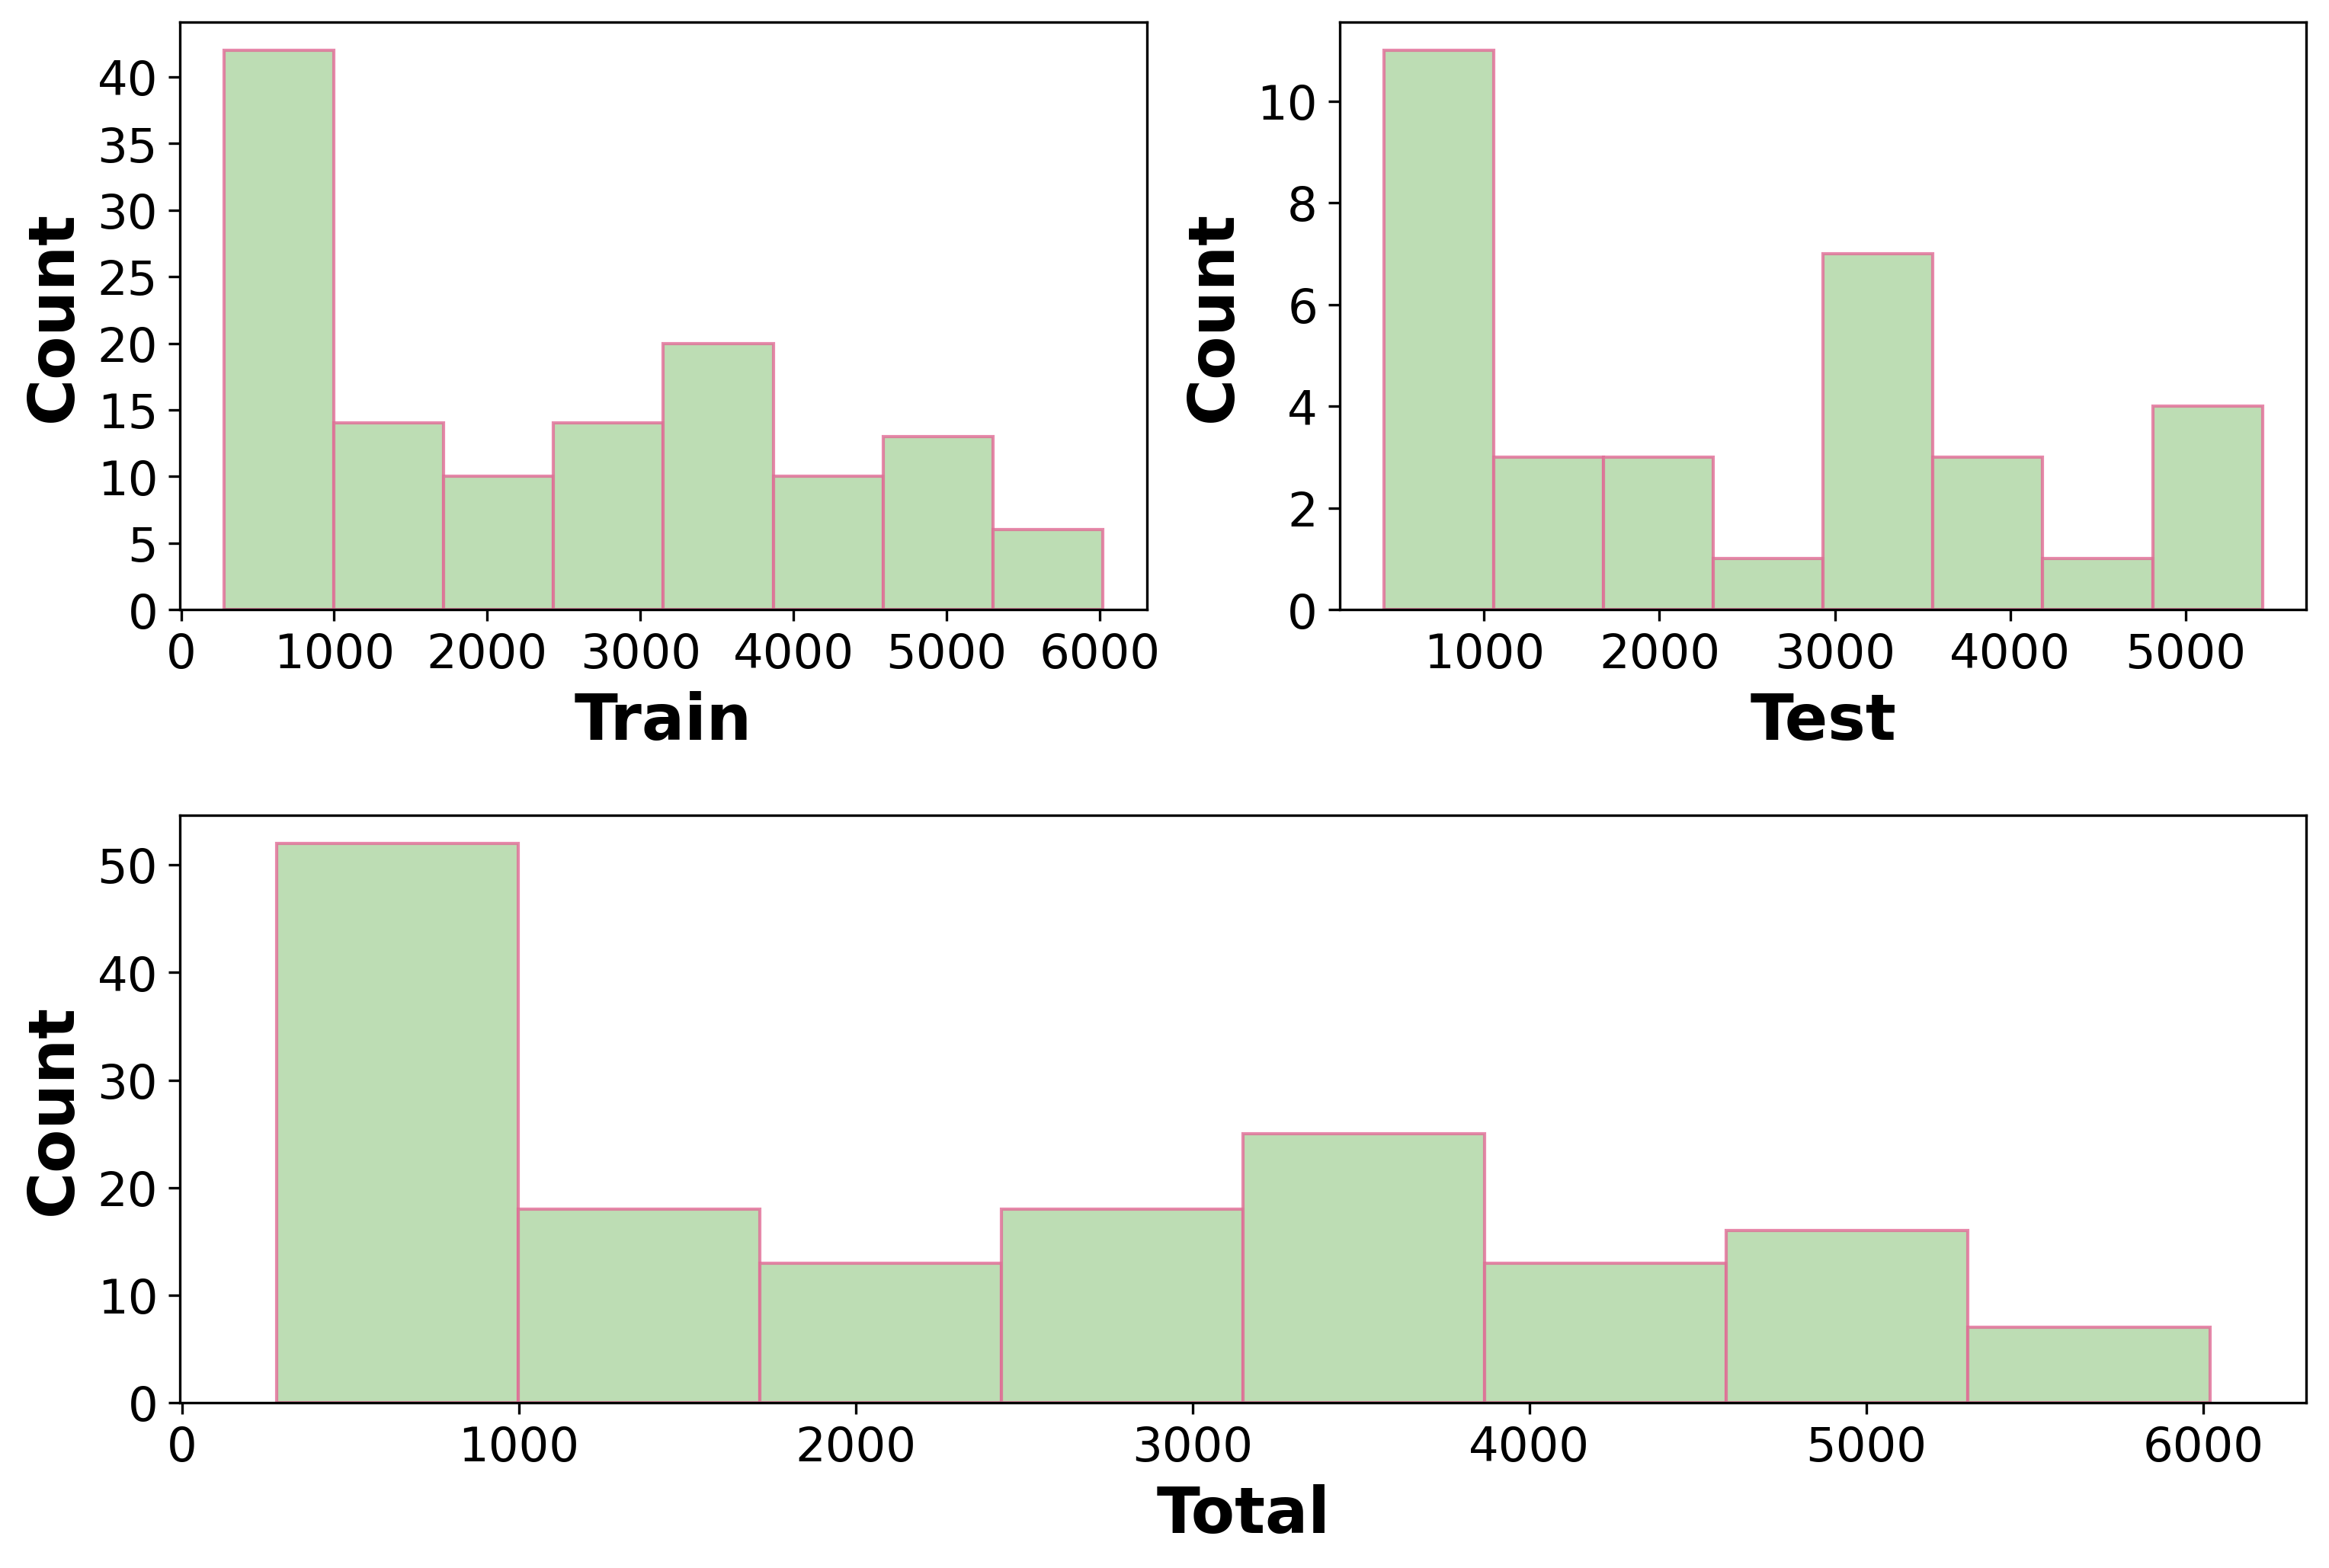

In [21]:
data_hea=pd.read_csv('HEA_data.csv')
data_hea=data_hea.iloc[:,2:-1]
X=data_hea.iloc[:,1:]
y=data_hea.iloc[:,0]
num_bins = round(1 + np.log2(data_hea.shape[0]))# 向下取整修改为四舍五入
features=data_hea.columns[1:]
target=data_hea.columns[0]
X_train,X_test,y_train,y_test= stratifed_sample_cut(data_hea,target,features,groups=num_bins,train_split_ratio=0.8,random_state=0)

plt.figure(figsize=(12, 8),dpi=300)

plt.subplot(2,1,2)
plt.hist(y,bins=num_bins,edgecolor="#e16c96",histtype="bar",color='#add5a2',alpha=0.8)# #5d655f郎烟灰 #add5a2嘉陵水绿 
plt.xlabel('Total',fontsize=20, fontweight='bold') #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('Count',fontsize=20, fontweight='bold') #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小


plt.subplot(2,2,1)
plt.hist(y_train,bins=num_bins,edgecolor="#e16c96",histtype="bar",color='#add5a2',alpha=0.8)# #5d655f郎烟灰 #add5a2嘉陵水绿 
plt.xlabel('Train',fontsize=20, fontweight='bold') #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('Count',fontsize=20, fontweight='bold') #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小

plt.subplot(2,2,2)
plt.hist(y_test,bins=num_bins,edgecolor="#e16c96",histtype="bar",color='#add5a2',alpha=0.8)# #5d655f郎烟灰 #add5a2嘉陵水绿 
plt.xlabel('Test',fontsize=20, fontweight='bold') #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('Count',fontsize=20, fontweight='bold') #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小

# 调整子图间距
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

42
14
10
14
20
10
13
6


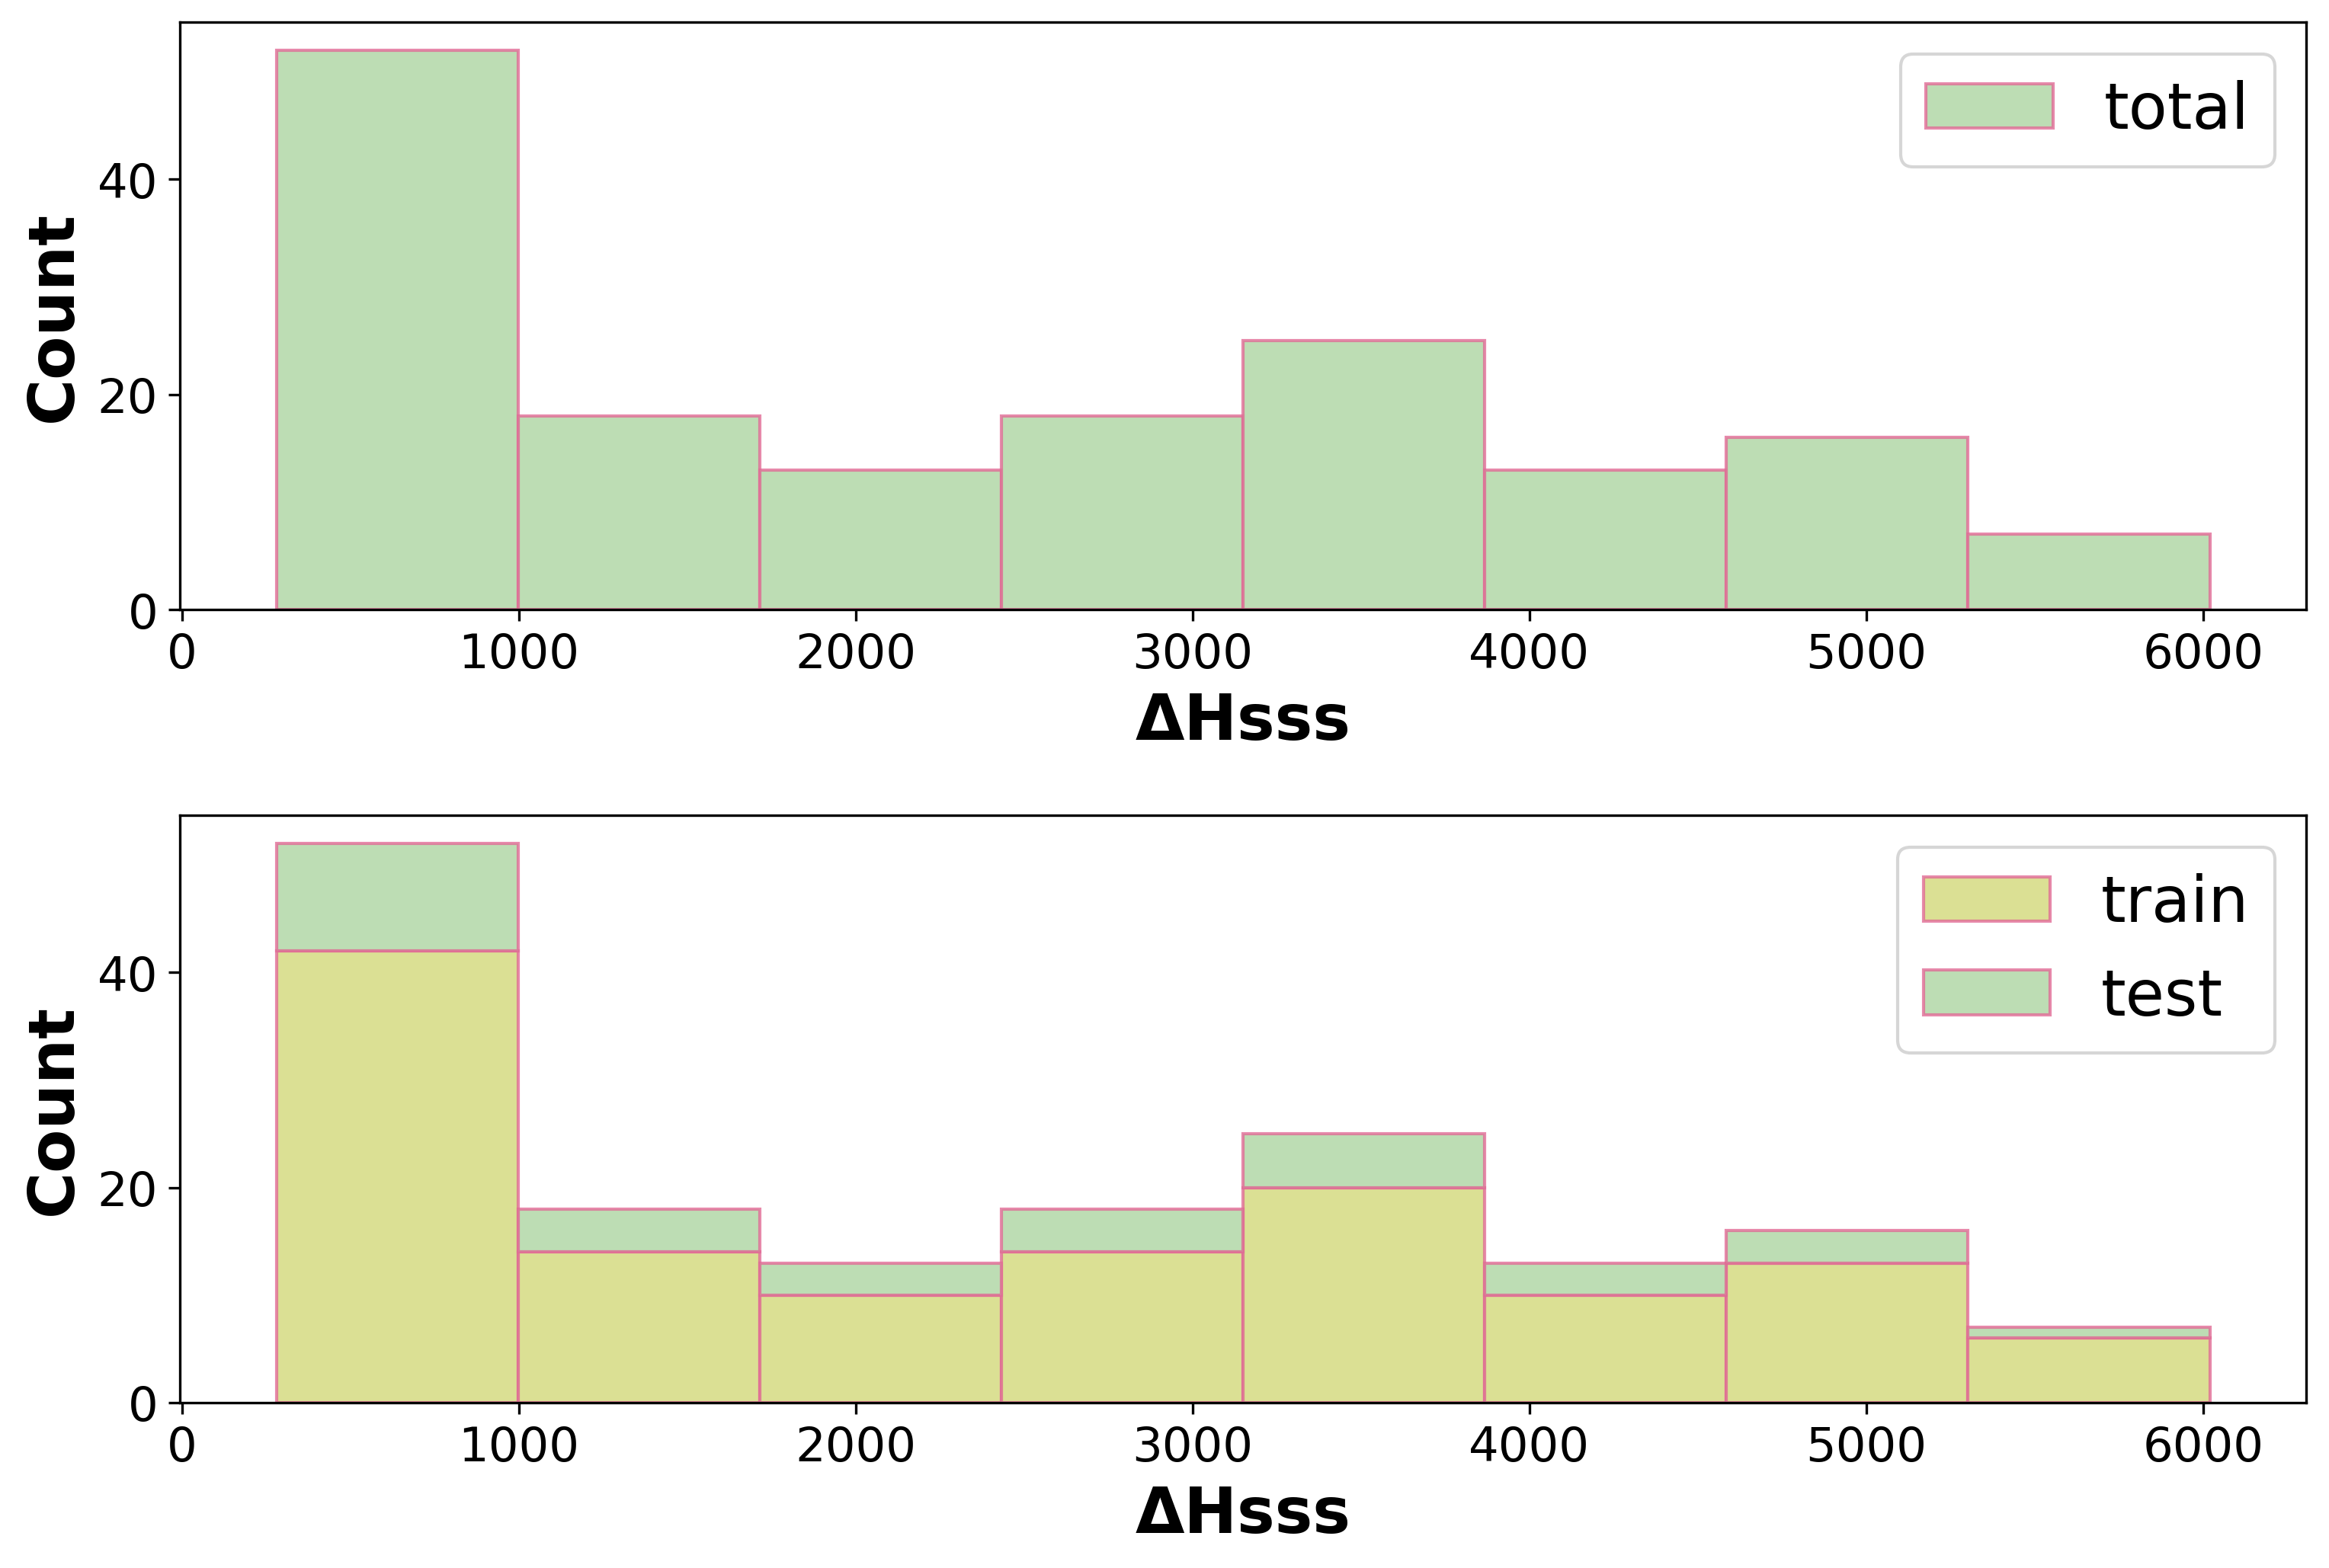

In [28]:
# 堆叠直方图
data_hea=pd.read_csv('HEA_data.csv')
data_hea=data_hea.iloc[:,2:-1]
X=data_hea.iloc[:,1:]
y=data_hea.iloc[:,0]
num_bins = round(1 + np.log2(data_hea.shape[0]))# 向下取整修改为四舍五入
features=data_hea.columns[1:]
target=data_hea.columns[0]
X_train,X_test,y_train,y_test= stratifed_sample_cut(data_hea,target,features,groups=num_bins,train_split_ratio=0.8,random_state=0)

plt.figure(figsize=(12, 8),dpi=300)
plt.subplot(2,1,1)
plt.hist(y,bins=num_bins,edgecolor="#e16c96",histtype="bar",color='#add5a2',alpha=0.8,label='total')# #5d655f郎烟灰 #add5a2嘉陵水绿 
plt.xlabel('ΔHsss',fontsize=20, fontweight='bold') #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('Count',fontsize=20, fontweight='bold') #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小
plt.legend(loc='upper right') 

plt.subplot(2,1,2)
plt.hist([y_train,y_test],bins=num_bins,edgecolor="#e16c96",color=["#d2d97a","#add5a2"],alpha=0.8,stacked=True,label=["train","test"])
plt.xlabel('ΔHsss',fontsize=20, fontweight='bold') #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('Count',fontsize=20, fontweight='bold') #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小
plt.rcParams.update({'font.size': 20})    
plt.legend(loc='upper right') 


# 调整子图间距
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)



# MIC—SHAP

In [23]:
# random_state=0
data_hea=pd.read_csv('HEA_data.csv')
data_hea=data_hea.iloc[:,2:-1]
X=data_hea.iloc[:,1:]
y=data_hea.iloc[:,0]
num_bins = round(1 + np.log2(data_hea.shape[0]))# 向下取整修改为四舍五入
features=data_hea.columns[1:]
target=data_hea.columns[0]
X_train,X_test,y_train,y_test= stratifed_sample_cut(data_hea,target,features,groups=num_bins,train_split_ratio=0.8,random_state=0)

42
14
10
14
20
10
13
6


## 计算SHAP values¶

In [24]:
#SVR MLP默认参数改一下
# KNeighborsRegressor() 默认时报错   'NoneType' object has no attribute 'split'
models=[LinearRegression(),Ridge(),KNeighborsRegressor(algorithm='kd_tree'),SVR(C=1000),MLPRegressor(hidden_layer_sizes=(100,80,60),random_state=0),XGBRegressor(random_state=0),RandomForestRegressor(random_state=0),CatBoostRegressor(verbose=False,random_state=0)]
modelname=['Linear','Ridge','KNN','SVR','MLP','XGBoost','RF','CatBoost']
import shap
score_shap_model_cut_0=pd.DataFrame([])
MIC_score=mic_xy(X_train,y_train)
for name,model in zip(modelname,models):
    print("="*60)
    print(name)
    model=model   #建立模型
    model.fit(X_train,y_train)
    explainer = shap.explainers.Permutation(model.predict, X_train)
    shap_values = explainer(X_train)
    #shap.summary_plot(shap_values, x, plot_type="bar",color='green')
    SHAP_score=pd.DataFrame(shap_values.values).apply(lambda x:abs(x)).mean()
    SHAP_score=round(pd.DataFrame(SHAP_score),6)
    score_shap_model_cut_0[name]=SHAP_score
score_shap_model_cut_0

Linear


Permutation explainer: 130it [00:14,  2.79it/s]                                                                        


Ridge


Permutation explainer: 130it [00:12,  1.89it/s]                                                                        


KNN


Permutation explainer: 130it [04:28,  2.16s/it]                                                                        


SVR


Permutation explainer: 130it [06:06,  2.91s/it]                                                                        


MLP


Permutation explainer: 130it [01:40,  1.17it/s]                                                                        


XGBoost


Permutation explainer: 130it [01:12,  1.52it/s]                                                                        


RF


Permutation explainer: 130it [01:43,  1.13it/s]                                                                        


CatBoost


Permutation explainer: 130it [00:42,  2.34it/s]                                                                        


,Linear,Ridge,KNN,SVR,MLP,XGBoost,RF,CatBoost
0,9.029047e+06,267.927060,21.007143,23.401024,5.364542,17.013404,10.429146,22.605453
1,3.066135e+06,560.089675,34.138492,38.212856,59.143932,19.532211,14.249573,18.331627
2,9.831339e+05,183.663188,22.105796,23.674877,7.302445,19.070601,3.518072,18.522022
3,7.633336e+06,365.145314,26.088488,31.480144,15.739905,116.941314,6.719554,14.350065
4,1.012871e+07,91.589601,21.629731,20.514155,12.679774,1198.102713,369.106865,126.482748
5,1.279846e+05,140.984308,18.397905,14.486472,41.071905,2.833526,6.101003,19.850837
6,1.619578e+07,32.002746,19.791955,17.287313,9.600396,11.399671,20.281052,33.189466
7,2.662637e+07,92.401892,21.562742,17.965899,10.938967,180.823671,87.113416,57.403347
8,3.051396e+06,297.040687,31.035122,32.852108,24.319569,18.409854,12.563052,26.663074
9,1.283428e+06,63.568645,18.047409,20.211202,25.530646,6.154677,9.687376,19.470584


In [25]:
score_shap_model_cut_0['MIC']=MIC_score['Score_MIC']
score_shap_model_cut_0=pd.DataFrame(MinMaxScaler().fit_transform(score_shap_model_cut_0),columns=modelname+['MIC'])
score_shap_model_cut_0.to_csv('20221025score_shap_model_cut_0.csv')

In [10]:
score_shap_model_cut_0=pd.read_csv('20221025score_shap_model_cut_0.csv')

In [26]:
#阈值
FN=len(X_train.columns)
thr_geo=geometric_mean([*range(1,FN+1)])
thr_logn=thr_log2n(FN)
thr_25=round(FN*0.25)
thr_50=round(FN*0.5)
thresholds_name=['thr_geo','thr_logn','25%','50%']
thresholds=[thr_geo,thr_logn,thr_25,thr_50]
thresholds

[21, 6, 14, 27]

## 定义不同阈值下权重优化函数

### 几何平均值

In [41]:
# 几何平均值
thr=thr_geo
thr_name='thr_geo'
print(thr)
cv5_score_sum_geo,cv10_score_sum_geo,test_score_sum_geo= mic_shap_thr_models(X_train,y_train,score_shap_model_cut_0,thr,thr_name)
cv5_score_sum_geo,cv10_score_sum_geo,test_score_sum_geo

21
Linear
test_r2: [0.694847, 0.694847, 0.685751, 0.685751, 0.685751, 0.5848, 0.658715, 0.642884, 0.642884, 0.716818, 0.673724]
test_r:  [0.854383, 0.854383, 0.85578, 0.85578, 0.85578, 0.81361, 0.834866, 0.825144, 0.825144, 0.860905, 0.833052]
test_rmse:  [873.723279, 873.723279, 886.649832, 886.649832, 886.649832, 1019.163174, 924.004534, 945.191086, 945.191086, 841.682215, 903.457629]
0.716818 9
test_a_best = 0.9
test_b_best= 0.09999999999999998
cv5_r :  [0.828102, 0.828102, 0.829234, 0.829234, 0.829234, 0.827342, 0.815124, 0.818695, 0.818695, 0.794887, 0.814794]
cv5_r2 :  [0.677051, 0.677051, 0.67938, 0.67938, 0.67938, 0.675092, 0.656044, 0.660459, 0.660459, 0.613844, 0.655458]
0.67938 2
a_best_cv5 = 0.2
b_best_cv5= 0.8
features_cv5= ['Vm', 'Rm', 'Xa', 'Rc', 'Xr', 'VEC', 'δE', 'ΔG', 'δHc', 'δG', 'ΔE', 'ΔK', 'Hc', 'Hs', 'δRc', 'ΔRc', 'Xp', 'δK', 'E', 'ΔVm', 'Ew']
cv10_r :  [0.835494, 0.835494, 0.836379, 0.836379, 0.836379, 0.830507, 0.82058, 0.822666, 0.822666, 0.794271, 0.831668]
cv

test_r2: [0.873942, 0.87546, 0.880621, 0.882052, 0.888236, 0.883902, 0.879488, 0.876855, 0.882976, 0.886037, 0.879066]
test_r:  [0.936039, 0.936706, 0.939598, 0.940368, 0.943678, 0.941249, 0.938882, 0.937598, 0.941463, 0.943457, 0.939117]
test_rmse:  [561.564576, 558.174561, 546.48565, 543.200606, 528.769542, 538.923006, 549.073628, 555.039356, 541.070125, 533.945262, 550.032868]
0.888236 4
test_a_best = 0.4
test_b_best= 0.6
cv5_r :  [0.926612, 0.925686, 0.925324, 0.923859, 0.92482, 0.925962, 0.929605, 0.928779, 0.93473, 0.935481, 0.935198]
cv5_r2 :  [0.858479, 0.856758, 0.856089, 0.853381, 0.855243, 0.857241, 0.864022, 0.862525, 0.87329, 0.875003, 0.874457]
0.875003 9
a_best_cv5 = 0.9
b_best_cv5= 0.09999999999999998
features_cv5= ['Rm', 'δG', 'Xa', 'ΔG', 'Xr', 'Vm', 'Xp', 'δE', 'ΔE', 'δVEC', 'VEC', 'δXr', 'ΔRc', 'Rc', 'Ew', 'δHc', 'Δν', 'ΔHc', 'ΔVm', 'δXa', 'Hs']
cv10_r :  [0.933246, 0.934927, 0.935469, 0.932218, 0.93415, 0.935729, 0.934267, 0.933767, 0.931885, 0.932946, 0.935559]
cv1

(         FN=21  Linearthr_name_cv5  Ridgethr_name_cv5  KNNthr_name_cv5  \
 0   a_best_cv5            0.200000           1.000000         0.000000   
 1   cv5_r_best            0.829234           0.903597         0.897635   
 2  cv5_r2_best            0.679380           0.815915         0.804146   
 3   test_r_cv5            0.855780           0.806343         0.800539   
 4  test_r2_cv5            0.685751           0.590646         0.617940   
 
    SVRthr_name_cv5  MLPthr_name_cv5  XGBoostthr_name_cv5  RFthr_name_cv5  \
 0         0.700000         0.800000             1.000000        0.900000   
 1         0.909256         0.861652             0.935382        0.935481   
 2         0.821694         0.737091             0.873559        0.875003   
 3         0.747975         0.663870             0.918176        0.943457   
 4         0.526969         0.394371             0.836813        0.886037   
 
    CatBoostthr_name_cv5  
 0              0.900000  
 1              0.946361  
 2 

In [42]:
cv5_score_sum_geo

,FN=21,Linearthr_name_cv5,Ridgethr_name_cv5,KNNthr_name_cv5,SVRthr_name_cv5,MLPthr_name_cv5,XGBoostthr_name_cv5,RFthr_name_cv5,CatBoostthr_name_cv5
0,a_best_cv5,0.200000,1.000000,0.000000,0.700000,0.800000,1.000000,0.900000,0.900000
1,cv5_r_best,0.829234,0.903597,0.897635,0.909256,0.861652,0.935382,0.935481,0.946361
2,cv5_r2_best,0.679380,0.815915,0.804146,0.821694,0.737091,0.873559,0.875003,0.894453
3,test_r_cv5,0.855780,0.806343,0.800539,0.747975,0.663870,0.918176,0.943457,0.940987
4,test_r2_cv5,0.685751,0.590646,0.617940,0.526969,0.394371,0.836813,0.886037,0.880719


In [44]:
cv5_score_sum_geo.to_csv('20221025cv5_score_sum_geo.csv')

In [45]:
cv10_score_sum_geo

,FN=21,Linearthr_name_cv10,Ridgethr_name_cv10,KNNthr_name_cv10,SVRthr_name_cv10,MLPthr_name_cv10,XGBoostthr_name_cv10,RFthr_name_cv10,CatBoostthr_name_cv10
0,a_best_cv10,0.200000,1.000000,0.000000,1.000000,0.800000,1.000000,0.500000,0.900000
1,cv10_r_best,0.836379,0.903621,0.910100,0.916935,0.858631,0.933646,0.935729,0.948056
2,cv10_r2_best,0.692828,0.816224,0.826253,0.835521,0.731160,0.870432,0.875439,0.898576
3,test_r_cv10,0.855780,0.806343,0.800539,0.753260,0.663870,0.918176,0.941249,0.940987
4,test_r2_cv10,0.685751,0.590646,0.617940,0.533164,0.394371,0.836813,0.883902,0.880719


In [46]:
cv10_score_sum_geo.to_csv('20221025cv10_score_sum_geo.csv')

In [47]:
test_score_sum_geo

,FN=21,Linearthr_name_test,Ridgethr_name_test,KNNthr_name_test,SVRthr_name_test,MLPthr_name_test,XGBoostthr_name_test,RFthr_name_test,CatBoostthr_name_test
0,a_best_test,0.900000,1.000000,0.000000,0.200000,1.000000,0.000000,0.400000,0.700000
1,cv5_r_t,0.794887,0.903597,0.897635,0.893270,0.861378,0.911745,0.924820,0.937618
2,cv5_r2_t,0.613844,0.815915,0.804146,0.775700,0.735584,0.826869,0.855243,0.878557
3,cv10_r_t,0.794271,0.903621,0.910100,0.892657,0.858870,0.931882,0.934150,0.937247
4,cv10_r2_t,0.610538,0.816224,0.826253,0.778703,0.730728,0.867141,0.872519,0.878431
5,test_r_best,0.860905,0.806343,0.800539,0.780677,0.672913,0.954103,0.943678,0.951596
6,test_r2_best,0.716818,0.590646,0.617940,0.559633,0.404347,0.908263,0.888236,0.905004


In [48]:
test_score_sum_geo.to_csv('20221025test_score_sum_geo.csv')

### log2n

In [49]:
thr=thr_logn
thr_name='thr_logn'
print(thr)
cv5_score_sum_logn,cv10_score_sum_logn,test_score_sum_logn= mic_shap_thr_models(X_train,y_train,score_shap_model_cut_0,thr,thr_name)
cv5_score_sum_logn,cv10_score_sum_logn,test_score_sum_logn

6
Linear
test_r2: [0.388782, 0.388782, 0.388782, 0.388782, 0.388782, 0.388782, 0.388782, 0.380533, 0.380533, 0.536993, 0.536993]
test_r:  [0.637248, 0.637248, 0.637248, 0.637248, 0.637248, 0.637248, 0.637248, 0.634753, 0.634753, 0.733477, 0.733477]
test_rmse:  [1236.554605, 1236.554605, 1236.554605, 1236.554605, 1236.554605, 1236.554605, 1236.554605, 1244.870738, 1244.870738, 1076.239735, 1076.239735]
0.536993 9
test_a_best = 0.9
test_b_best= 0.09999999999999998
cv5_r :  [0.583922, 0.583922, 0.583922, 0.583922, 0.583922, 0.583922, 0.583922, 0.593008, 0.593008, 0.758537, 0.758537]
cv5_r2 :  [0.337332, 0.337332, 0.337332, 0.337332, 0.337332, 0.337332, 0.337332, 0.346027, 0.346027, 0.572478, 0.572478]
0.572478 9
a_best_cv5 = 0.9
b_best_cv5= 0.09999999999999998
features_cv5= ['Vm', 'Rc', 'Rm', 'E', 'VEC', 'ν']
cv10_r :  [0.586783, 0.586783, 0.586783, 0.586783, 0.586783, 0.586783, 0.586783, 0.598221, 0.598221, 0.767785, 0.767785]
cv10_r2 :  [0.340968, 0.340968, 0.340968, 0.340968, 0.340968,

test_r2: [0.895777, 0.881067, 0.880462, 0.873609, 0.876945, 0.876945, 0.876945, 0.868219, 0.864913, 0.866756, 0.867266]
test_r:  [0.947262, 0.93995, 0.938369, 0.934964, 0.937015, 0.937015, 0.937015, 0.931841, 0.930184, 0.931073, 0.931422]
test_rmse:  [510.618422, 545.465142, 546.84893, 562.306224, 554.835555, 554.835555, 554.835555, 574.171852, 581.328196, 577.349706, 576.243825]
0.895777 0
test_a_best = 0.0
test_b_best= 1.0
cv5_r :  [0.950532, 0.951491, 0.944645, 0.947352, 0.943246, 0.943246, 0.943246, 0.943291, 0.942142, 0.940762, 0.942067]
cv5_r2 :  [0.902647, 0.904503, 0.891882, 0.897117, 0.889502, 0.889502, 0.889502, 0.889611, 0.887258, 0.884769, 0.887231]
0.904503 1
a_best_cv5 = 0.1
b_best_cv5= 0.9
features_cv5= ['Xa', 'Rm', 'Xr', 'Vm', 'VEC', 'Rc']
cv10_r :  [0.95276, 0.953212, 0.942603, 0.942606, 0.939894, 0.939894, 0.939894, 0.939457, 0.941047, 0.939107, 0.94054]
cv10_r2 :  [0.907455, 0.908444, 0.887826, 0.887775, 0.883144, 0.883144, 0.883144, 0.882313, 0.885435, 0.8816, 0.884

(          FN=6  Linearthr_logn_cv5  Ridgethr_logn_cv5  KNNthr_logn_cv5  \
 0   a_best_cv5            0.900000           0.400000         0.000000   
 1   cv5_r_best            0.758537           0.712051         0.936287   
 2  cv5_r2_best            0.572478           0.506305         0.876617   
 3   test_r_cv5            0.733477           0.698664         0.897566   
 4  test_r2_cv5            0.536993           0.473268         0.798660   
 
    SVRthr_logn_cv5  MLPthr_logn_cv5  XGBoostthr_logn_cv5  RFthr_logn_cv5  \
 0         0.500000         0.700000             0.600000        0.800000   
 1         0.904758         0.807015             0.938966        0.939783   
 2         0.812226         0.628594             0.879193        0.883082   
 3         0.772972         0.620668             0.928084        0.950216   
 4         0.567348         0.311856             0.859636        0.901678   
 
    CatBoostthr_logn_cv5  
 0              0.100000  
 1              0.951491  
 2 

In [50]:
cv5_score_sum_logn

,FN=6,Linearthr_logn_cv5,Ridgethr_logn_cv5,KNNthr_logn_cv5,SVRthr_logn_cv5,MLPthr_logn_cv5,XGBoostthr_logn_cv5,RFthr_logn_cv5,CatBoostthr_logn_cv5
0,a_best_cv5,0.900000,0.400000,0.000000,0.500000,0.700000,0.600000,0.800000,0.100000
1,cv5_r_best,0.758537,0.712051,0.936287,0.904758,0.807015,0.938966,0.939783,0.951491
2,cv5_r2_best,0.572478,0.506305,0.876617,0.812226,0.628594,0.879193,0.883082,0.904503
3,test_r_cv5,0.733477,0.698664,0.897566,0.772972,0.620668,0.928084,0.950216,0.939950
4,test_r2_cv5,0.536993,0.473268,0.798660,0.567348,0.311856,0.859636,0.901678,0.881067


In [51]:
cv5_score_sum_logn.to_csv('20221025cv5_score_sum_logn.csv')

In [52]:
cv10_score_sum_logn

,FN=6,Linearthr_logn_cv10,Ridgethr_logn_cv10,KNNthr_logn_cv10,SVRthr_logn_cv10,MLPthr_logn_cv10,XGBoostthr_logn_cv10,RFthr_logn_cv10,CatBoostthr_logn_cv10
0,a_best_cv10,0.900000,0.400000,0.000000,0.300000,0.700000,0.000000,0.000000,0.100000
1,cv10_r_best,0.767785,0.717775,0.940667,0.901626,0.800368,0.941483,0.946191,0.953212
2,cv10_r2_best,0.588652,0.514417,0.884312,0.805743,0.615501,0.884562,0.894991,0.908444
3,test_r_cv10,0.733477,0.698664,0.897566,0.835715,0.620668,0.953654,0.946976,0.939950
4,test_r2_cv10,0.536993,0.473268,0.798660,0.682381,0.311856,0.906122,0.896762,0.881067


In [53]:
cv10_score_sum_logn.to_csv('20221025cv10_score_sum_logn.csv')

In [54]:
test_score_sum_logn

,FN=6,Linearthr_logn_test,Ridgethr_logn_test,KNNthr_logn_test,SVRthr_logn_test,MLPthr_logn_test,XGBoostthr_logn_test,RFthr_logn_test,CatBoostthr_logn_test
0,a_best_test,0.900000,0.200000,0.000000,0.200000,0.700000,0.000000,1.000000,0.000000
1,cv5_r_t,0.758537,0.675374,0.936287,0.898190,0.807015,0.918640,0.938912,0.950532
2,cv5_r2_t,0.572478,0.455543,0.876617,0.798892,0.628594,0.841270,0.881552,0.902647
3,cv10_r_t,0.767785,0.677359,0.940667,0.893558,0.800368,0.941483,0.942038,0.952760
4,cv10_r2_t,0.588652,0.458282,0.884312,0.793582,0.615501,0.884562,0.887393,0.907455
5,test_r_best,0.733477,0.702495,0.897566,0.840671,0.620668,0.953654,0.957113,0.947262
6,test_r2_best,0.536993,0.483996,0.798660,0.688430,0.311856,0.906122,0.914133,0.895777


In [55]:
test_score_sum_logn.to_csv('20221025test_score_sum_logn.scv')

### 25%

In [56]:
thr=thr_25
thr_name='thr_25'
print(thr)
cv5_score_sum_25,cv10_score_sum_25,test_score_sum_25= mic_shap_thr_models(X_train,y_train,score_shap_model_cut_0,thr,thr_name)
cv5_score_sum_25,cv10_score_sum_25,test_score_sum_25

14
Linear
test_r2: [0.62875, 0.650597, 0.650597, 0.650597, 0.616435, 0.668113, 0.650005, 0.650005, 0.582352, 0.710282, 0.71051]
test_r:  [0.811369, 0.825261, 0.825261, 0.825261, 0.814719, 0.823854, 0.820778, 0.820778, 0.779929, 0.843825, 0.843959]
test_rmse:  [963.714232, 934.928397, 934.928397, 934.928397, 979.568358, 911.192451, 935.720089, 935.720089, 1022.163199, 851.339122, 851.004871]
0.71051 10
test_a_best = 1.0
test_b_best= 0.0
cv5_r :  [0.834921, 0.812569, 0.812569, 0.812569, 0.784459, 0.800492, 0.780114, 0.780114, 0.776349, 0.797994, 0.798001]
cv5_r2 :  [0.693219, 0.65263, 0.65263, 0.65263, 0.600653, 0.633447, 0.59874, 0.59874, 0.59125, 0.628762, 0.628769]
0.693219 0
a_best_cv5 = 0.0
b_best_cv5= 1.0
features_cv5= ['Xa', 'Rm', 'Vm', 'Xr', 'Rc', 'VEC', 'δE', 'ΔG', 'δHc', 'δG', 'ΔE', 'ΔK', 'Hc', 'δRc']
cv10_r :  [0.852308, 0.828362, 0.828362, 0.828362, 0.809161, 0.810242, 0.789999, 0.789999, 0.785069, 0.809742, 0.809749]
cv10_r2 :  [0.724856, 0.681826, 0.681826, 0.681826, 0.6479

test_r2: [0.894169, 0.901681, 0.893624, 0.900655, 0.880089, 0.880089, 0.887679, 0.89203, 0.884597, 0.897962, 0.886625]
test_r:  [0.945716, 0.949919, 0.945886, 0.949146, 0.93822, 0.93822, 0.942295, 0.94503, 0.941181, 0.94818, 0.941938]
test_rmse:  [514.543036, 495.944577, 515.867293, 498.526606, 547.702191, 547.702191, 530.085251, 519.715686, 537.30848, 505.238226, 532.567531]
0.901681 1
test_a_best = 0.1
test_b_best= 0.9
cv5_r :  [0.935921, 0.937546, 0.938699, 0.935797, 0.937487, 0.937487, 0.943444, 0.944523, 0.943322, 0.942734, 0.947174]
cv5_r2 :  [0.875555, 0.878682, 0.881008, 0.87534, 0.878618, 0.878618, 0.889838, 0.891557, 0.889365, 0.888334, 0.896457]
0.896457 10
a_best_cv5 = 1.0
b_best_cv5= 0.0
features_cv5= ['Xr', 'δG', 'Rm', 'δE', 'ΔG', 'Xa', 'δXr', 'VEC', 'Vm', 'ΔE', 'ΔXr', 'δRc', 'δHc', 'ΔK']
cv10_r :  [0.938101, 0.938655, 0.941138, 0.940048, 0.94043, 0.94043, 0.943989, 0.940645, 0.942257, 0.945541, 0.942645]
cv10_r2 :  [0.879975, 0.880994, 0.88563, 0.883611, 0.884357, 0.8843

(         FN=14  Linearthr_25_cv5  Ridgethr_25_cv5  KNNthr_25_cv5  \
 0   a_best_cv5          0.000000         1.000000       0.000000   
 1   cv5_r_best          0.834921         0.860856       0.897716   
 2  cv5_r2_best          0.693219         0.740303       0.805293   
 3   test_r_cv5          0.811369         0.769964       0.805291   
 4  test_r2_cv5          0.628750         0.533619       0.632079   
 
    SVRthr_25_cv5  MLPthr_25_cv5  XGBoostthr_25_cv5  RFthr_25_cv5  \
 0       0.500000       1.000000           1.000000      1.000000   
 1       0.906108       0.852075           0.941337      0.938788   
 2       0.817956       0.710265           0.885372      0.881157   
 3       0.757495       0.646090           0.910375      0.946292   
 4       0.539441       0.332845           0.814559      0.891595   
 
    CatBoostthr_25_cv5  
 0            1.000000  
 1            0.947174  
 2            0.896457  
 3            0.941938  
 4            0.886625  ,
           FN=14 

In [57]:
cv5_score_sum_25

,FN=14,Linearthr_25_cv5,Ridgethr_25_cv5,KNNthr_25_cv5,SVRthr_25_cv5,MLPthr_25_cv5,XGBoostthr_25_cv5,RFthr_25_cv5,CatBoostthr_25_cv5
0,a_best_cv5,0.000000,1.000000,0.000000,0.500000,1.000000,1.000000,1.000000,1.000000
1,cv5_r_best,0.834921,0.860856,0.897716,0.906108,0.852075,0.941337,0.938788,0.947174
2,cv5_r2_best,0.693219,0.740303,0.805293,0.817956,0.710265,0.885372,0.881157,0.896457
3,test_r_cv5,0.811369,0.769964,0.805291,0.757495,0.646090,0.910375,0.946292,0.941938
4,test_r2_cv5,0.628750,0.533619,0.632079,0.539441,0.332845,0.814559,0.891595,0.886625


In [58]:
cv5_score_sum_25.to_csv('20221025cv5_score_sum_25.csv')

In [59]:
cv10_score_sum_25

,FN=14,Linearthr_25_cv10,Ridgethr_25_cv10,KNNthr_25_cv10,SVRthr_25_cv10,MLPthr_25_cv10,XGBoostthr_25_cv10,RFthr_25_cv10,CatBoostthr_25_cv10
0,a_best_cv10,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.900000,0.900000
1,cv10_r_best,0.852308,0.866379,0.907526,0.911486,0.840105,0.933367,0.937451,0.945541
2,cv10_r2_best,0.724856,0.750242,0.823075,0.827187,0.685492,0.870797,0.878607,0.893947
3,test_r_cv10,0.811369,0.769964,0.805291,0.715661,0.646090,0.952866,0.943383,0.948180
4,test_r2_cv10,0.628750,0.533619,0.632079,0.465530,0.332845,0.905280,0.885701,0.897962


In [60]:
cv10_score_sum_25.to_csv('20221025cv10_score_sum_25.csv')

In [61]:
test_score_sum_25

,FN=14,Linearthr_25_test,Ridgethr_25_test,KNNthr_25_test,SVRthr_25_test,MLPthr_25_test,XGBoostthr_25_test,RFthr_25_test,CatBoostthr_25_test
0,a_best_test,1.000000,0.100000,0.000000,0.000000,1.000000,0.000000,1.000000,0.100000
1,cv5_r_t,0.798001,0.845491,0.897716,0.882610,0.852075,0.920768,0.938788,0.937546
2,cv5_r2_t,0.628769,0.714725,0.805293,0.751900,0.710265,0.845773,0.881157,0.878682
3,cv10_r_t,0.809749,0.846496,0.907526,0.889705,0.840105,0.933367,0.936893,0.938655
4,cv10_r2_t,0.649617,0.716498,0.823075,0.766409,0.685492,0.870797,0.877586,0.880994
5,test_r_best,0.843959,0.802891,0.805291,0.782585,0.646090,0.952866,0.946292,0.949919
6,test_r2_best,0.710510,0.632532,0.632079,0.570102,0.332845,0.905280,0.891595,0.901681


In [62]:
test_score_sum_25.to_csv('20221025test_score_sum_25.csv')

### 50%

In [63]:
thr=thr_50
thr_name='thr_50'
print(thr)
cv5_score_sum_50,cv10_score_sum_50,test_score_sum_50= mic_shap_thr_models(X_train,y_train,score_shap_model_cut_0,thr,thr_name)
cv5_score_sum_50,cv10_score_sum_50,test_score_sum_50

27
Linear
test_r2: [0.537157, 0.537157, 0.537157, 0.537162, 0.537162, 0.537162, 0.571213, 0.571213, 0.571213, 0.576339, 0.58666]
test_r:  [0.800437, 0.800437, 0.800437, 0.800426, 0.800426, 0.800426, 0.817935, 0.817935, 0.817935, 0.821815, 0.803528]
test_rmse:  [1076.04915, 1076.04915, 1076.04915, 1076.04373, 1076.04373, 1076.04373, 1035.705198, 1035.705198, 1035.705198, 1029.495719, 1016.878395]
0.58666 10
test_a_best = 1.0
test_b_best= 0.0
cv5_r :  [0.784145, 0.784145, 0.784145, 0.784146, 0.784146, 0.784146, 0.784804, 0.784804, 0.784804, 0.78831, 0.828347]
cv5_r2 :  [0.565183, 0.565183, 0.565183, 0.56518, 0.56518, 0.56518, 0.571518, 0.571518, 0.571518, 0.576933, 0.673659]
0.673659 10
a_best_cv5 = 1.0
b_best_cv5= 0.0
features_cv5= ['Vm', 'Rc', 'Rm', 'E', 'ν', 'VEC', 'Xa', 'Xp', 'Ec', 'K', 'Hs', 'Xr', 'Hc', 'Xm', 'G', 'e/a', 'Ew', 'Ri', 'δVm', 'δRc', 'ΔRi', 'ΔVm', 'δRi', 'δHs', 'δVEC', 'δG', 'δE']
cv10_r :  [0.82611, 0.82611, 0.82611, 0.826117, 0.826117, 0.826117, 0.819529, 0.819529, 0.

test_r2: [0.873119, 0.86715, 0.868302, 0.862366, 0.854706, 0.864679, 0.860038, 0.868996, 0.867194, 0.866656, 0.872339]
test_r:  [0.935122, 0.932108, 0.932679, 0.929364, 0.92537, 0.931299, 0.928856, 0.93373, 0.932762, 0.932345, 0.935126]
test_rmse:  [563.395544, 576.495499, 573.989993, 586.78455, 602.891237, 581.832754, 591.724415, 572.475517, 576.400117, 577.566123, 565.1251]
0.873119 0
test_a_best = 0.0
test_b_best= 1.0
cv5_r :  [0.928327, 0.926592, 0.929098, 0.927481, 0.927428, 0.933315, 0.933432, 0.934688, 0.933878, 0.935185, 0.935971]
cv5_r2 :  [0.861762, 0.858501, 0.863211, 0.860184, 0.860099, 0.870979, 0.871186, 0.873514, 0.871924, 0.874403, 0.875644]
0.875644 10
a_best_cv5 = 1.0
b_best_cv5= 0.0
features_cv5= ['Rm', 'δG', 'Xa', 'ΔG', 'Xp', 'Xr', 'Vm', 'δE', 'δVEC', 'δXr', 'ΔE', 'VEC', 'Δν', 'ΔRc', 'Ew', 'δXa', 'Rc', 'ΔHc', 'δν', 'ΔVm', 'δRi', 'δEc', 'ΔXr', 'K', 'Hs', 'ΔRm', 'Xm']
cv10_r :  [0.93234, 0.932921, 0.93557, 0.934465, 0.93421, 0.930311, 0.931117, 0.932364, 0.932082, 0.9

(         FN=27  Linearthr_50_cv5  Ridgethr_50_cv5  KNNthr_50_cv5  \
 0   a_best_cv5          1.000000         0.900000       0.000000   
 1   cv5_r_best          0.828347         0.899331       0.906997   
 2  cv5_r2_best          0.673659         0.807919       0.815808   
 3   test_r_cv5          0.803528         0.819853       0.807895   
 4  test_r2_cv5          0.586660         0.624721       0.621653   
 
    SVRthr_50_cv5  MLPthr_50_cv5  XGBoostthr_50_cv5  RFthr_50_cv5  \
 0       0.500000       0.800000           1.000000      1.000000   
 1       0.914269       0.861883           0.938734      0.935971   
 2       0.830260       0.738269           0.880590      0.875644   
 3       0.774239       0.685634           0.920601      0.935126   
 4       0.576757       0.431089           0.841647      0.872339   
 
    CatBoostthr_50_cv5  
 0            0.700000  
 1            0.945723  
 2            0.893715  
 3            0.936684  
 4            0.873875  ,
           FN=27 

In [64]:
cv5_score_sum_50

,FN=27,Linearthr_50_cv5,Ridgethr_50_cv5,KNNthr_50_cv5,SVRthr_50_cv5,MLPthr_50_cv5,XGBoostthr_50_cv5,RFthr_50_cv5,CatBoostthr_50_cv5
0,a_best_cv5,1.000000,0.900000,0.000000,0.500000,0.800000,1.000000,1.000000,0.700000
1,cv5_r_best,0.828347,0.899331,0.906997,0.914269,0.861883,0.938734,0.935971,0.945723
2,cv5_r2_best,0.673659,0.807919,0.815808,0.830260,0.738269,0.880590,0.875644,0.893715
3,test_r_cv5,0.803528,0.819853,0.807895,0.774239,0.685634,0.920601,0.935126,0.936684
4,test_r2_cv5,0.586660,0.624721,0.621653,0.576757,0.431089,0.841647,0.872339,0.873875


In [65]:
cv5_score_sum_50.to_csv('20221025cv5_score_sum_50.csv')

In [66]:
cv10_score_sum_50

,FN=27,Linearthr_50_cv10,Ridgethr_50_cv10,KNNthr_50_cv10,SVRthr_50_cv10,MLPthr_50_cv10,XGBoostthr_50_cv10,RFthr_50_cv10,CatBoostthr_50_cv10
0,a_best_cv10,1.000000,0.800000,0.000000,0.900000,1.000000,0.800000,0.200000,0.900000
1,cv10_r_best,0.839946,0.899437,0.917872,0.918512,0.854099,0.937121,0.935570,0.949658
2,cv10_r2_best,0.695881,0.808375,0.836838,0.838437,0.721629,0.877856,0.875134,0.901489
3,test_r_cv10,0.803528,0.818928,0.807895,0.756436,0.676523,0.933871,0.932679,0.935068
4,test_r2_cv10,0.586660,0.617975,0.621653,0.542528,0.409548,0.870151,0.868302,0.870803


In [67]:
cv10_score_sum_50.to_csv('20221025cv10_score_sum_50.csv')

In [68]:
test_score_sum_50

,FN=27,Linearthr_50_test,Ridgethr_50_test,KNNthr_50_test,SVRthr_50_test,MLPthr_50_test,XGBoostthr_50_test,RFthr_50_test,CatBoostthr_50_test
0,a_best_test,1.000000,1.000000,0.000000,0.100000,0.600000,0.000000,0.000000,0.000000
1,cv5_r_t,0.828347,0.890319,0.906997,0.888913,0.838502,0.922438,0.928327,0.939841
2,cv5_r2_t,0.673659,0.791268,0.815808,0.774642,0.699436,0.848306,0.861762,0.883083
3,cv10_r_t,0.839946,0.890009,0.917872,0.897053,0.831839,0.929637,0.932340,0.946256
4,cv10_r2_t,0.695881,0.790489,0.836838,0.787836,0.686983,0.863442,0.869188,0.895359
5,test_r_best,0.803528,0.833199,0.807895,0.784692,0.683174,0.957398,0.935122,0.946649
6,test_r2_best,0.586660,0.650128,0.621653,0.583119,0.431883,0.916375,0.873119,0.895541


In [69]:
test_score_sum_50.to_csv('20221025test_score_sum_50.csv')

In [70]:
thresholds=[thr_geo,thr_logn,thr_25,thr_50]
thresholds

[21, 6, 14, 27]

### cv5_r2 可视化

In [4]:

cv5_6=pd.read_csv('20221025cv5_score_sum_logn.csv')
cv5_14=pd.read_csv('20221025cv5_score_sum_25.csv')
cv5_21=pd.read_csv('20221025cv5_score_sum_geo.csv')
cv5_27=pd.read_csv('20221025cv5_score_sum_50.csv')
thr_logn_cv5=(cv5_6.iloc[2,:].values[3:]).tolist()# 去掉了Linear模型
thr_25_cv5=(cv5_14.iloc[2,:].values[3:]).tolist()
thr_geo_cv5=(cv5_21.iloc[2,:].values[3:]).tolist()
thr_50_cv5=(cv5_27.iloc[2,:].values[3:]).tolist()

data1_sum_cv5=[]
#去掉了linear
x=['Ridge','KNN','SVR','MLP','XGBoost','RF','CatBoost']
for i  in range(len(x)):
    data1_sum_cv5+=[thr_logn_cv5[i]]+[thr_25_cv5[i]]+[thr_geo_cv5[i]]+[thr_50_cv5[i]]
data1_sum_cv5=pd.DataFrame(data1_sum_cv5,columns=['cv5_r2'])
# 模型名称重复
models_names=[]
for name in x:
    models_names+=[name]*4
models_names

data1_sum_cv5['models']=models_names
data1_sum_cv5['thr']=['thr_logn_cv5','thr_25_cv5','thr_geo_cv5','thr_50_cv5']*7
data1_sum_cv5

,cv5_r2,models,thr
0,0.506305,Ridge,thr_logn_cv5
1,0.740303,Ridge,thr_25_cv5
2,0.815915,Ridge,thr_geo_cv5
3,0.807919,Ridge,thr_50_cv5
4,0.876617,KNN,thr_logn_cv5
5,0.805293,KNN,thr_25_cv5
6,0.804146,KNN,thr_geo_cv5
7,0.815808,KNN,thr_50_cv5
8,0.812226,SVR,thr_logn_cv5
9,0.817956,SVR,thr_25_cv5


In [79]:
data1_sum_cv5.to_csv('20221026data1_sum_cv5.csv')

In [ ]:
plt.rcParams['font.sans-serif']=['Simhei'] #显示中文
plt.rcParams['axes.unicode_minus']=False   #显示负号
plt.rcParams['font.sans-serif'] = ['Times New Roman']

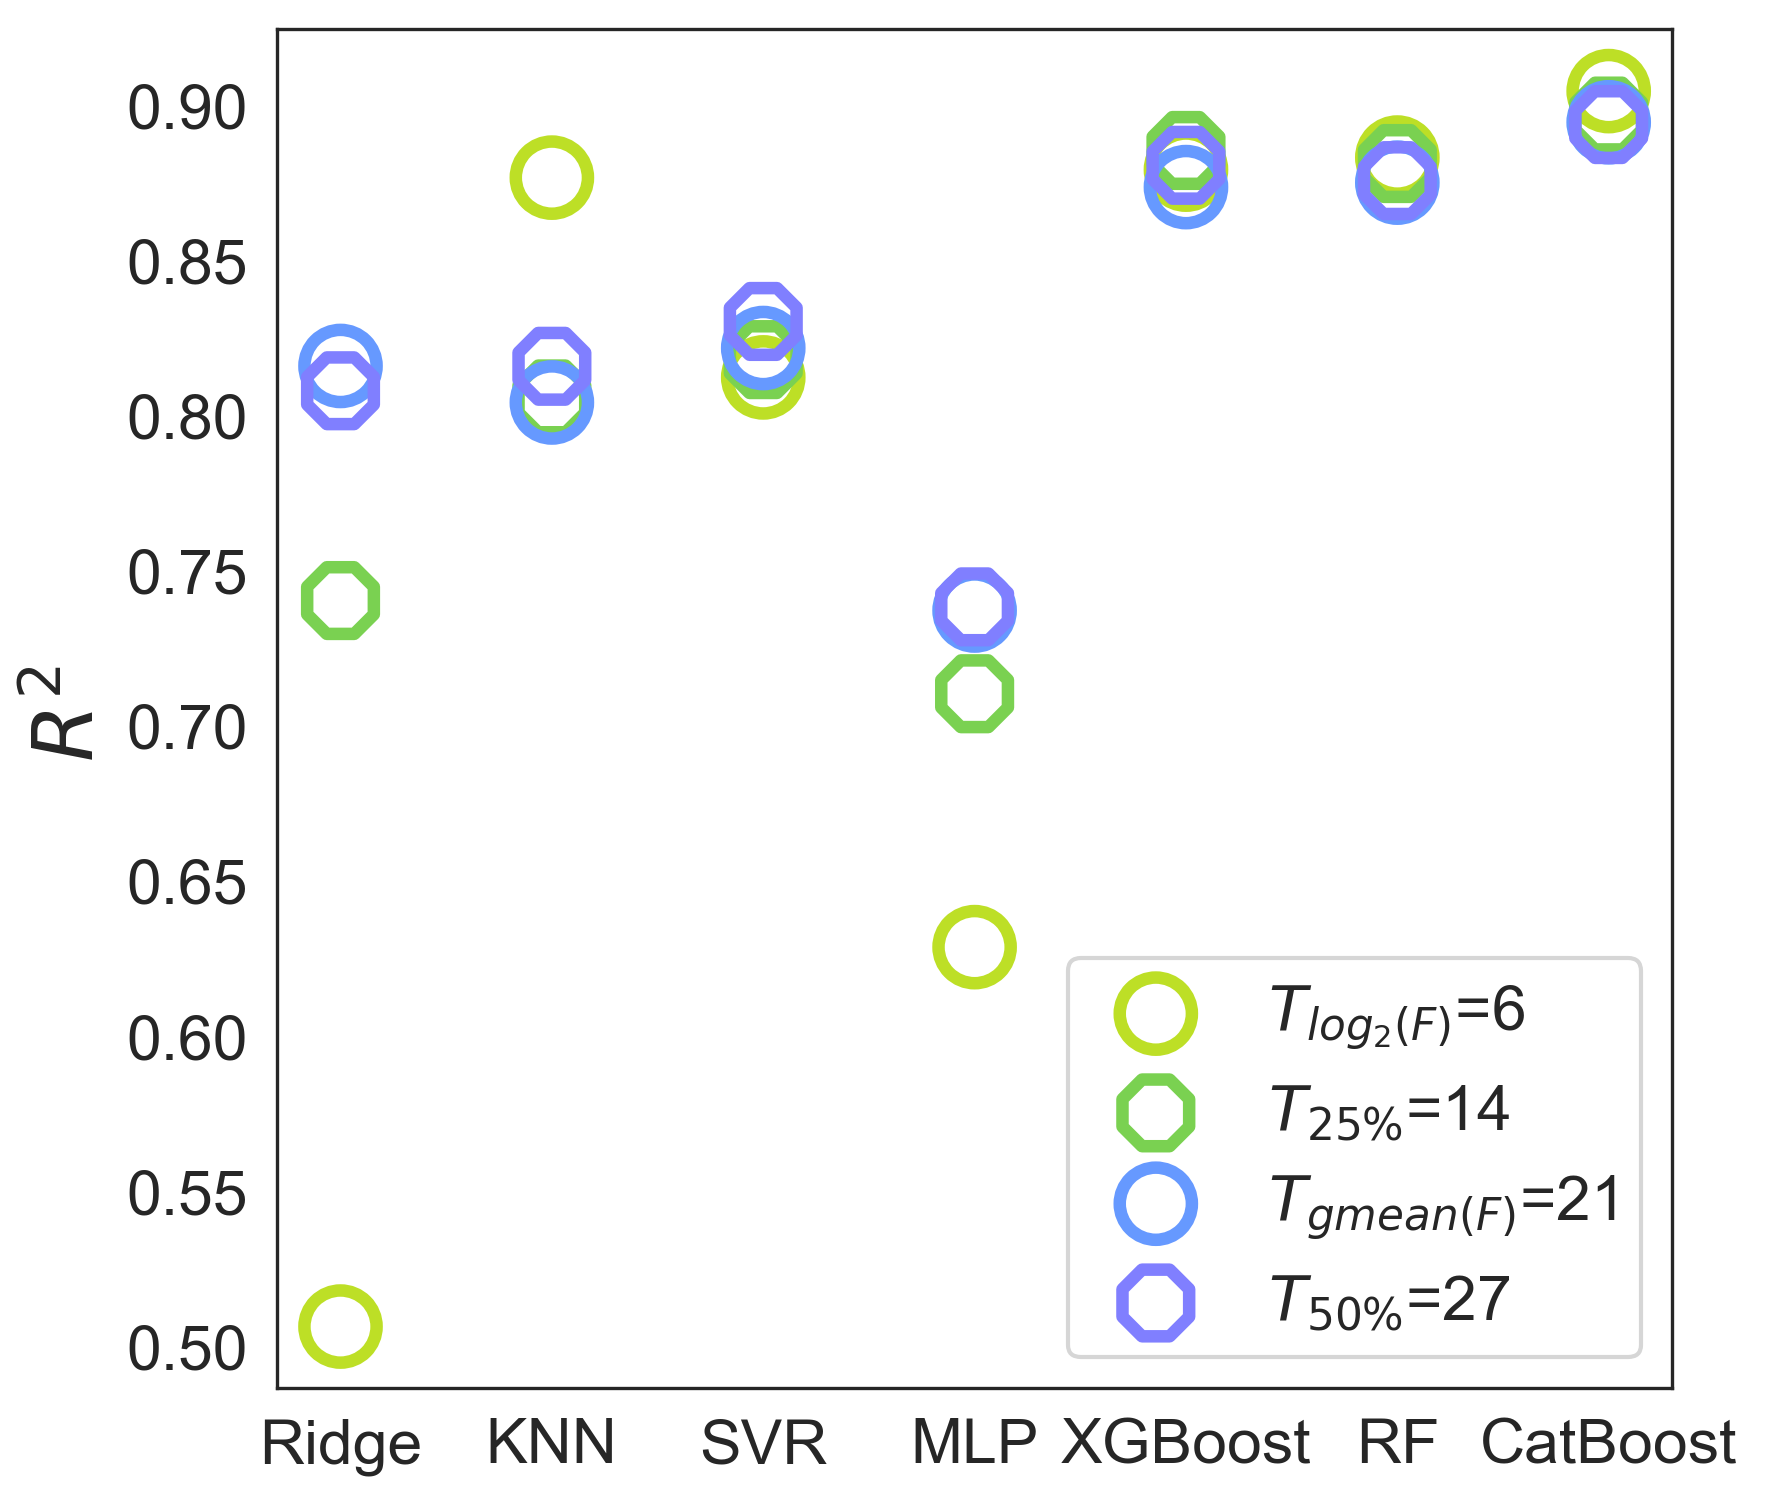

In [159]:
# 可视化

  
plt.figure(figsize=(6,6),dpi=300)
plt.rc('font',family='Times New Roman') 
sns.set_style("white") #设定整体背景风格
cm = plt.cm.get_cmap('viridis_r')
thr_sum=['thr_logn_cv5','thr_25_cv5','thr_geo_cv5','thr_50_cv5']
thr_=[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)]
#thr_=['thr_logn='+str(thr_logn),'thr_25='+str(thr_25),'thr_geo='+str(thr_geo),'thr_50='+str(thr_50)]
#colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.2),plt.cm.cool(0.3)]
#colors=['#f0c9cf','#93b5cf','#93d5dc','#83cbac']
colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.4),plt.cm.cool(0.5)]
#colors=['#44803F','#B4CF66','#FFEC5C','#FF5A33']
marker=['o','8','o','8']
P=['p1','p2','p3','p4']
for i in range(len(thr_sum)):
    P[i]=plt.scatter(data1_sum_cv5.loc[data1_sum_cv5['thr']==thr_sum[i],"models"]
                    ,data1_sum_cv5.loc[data1_sum_cv5['thr']==thr_sum[i],"cv5_r2"]
                    ,s=300
                    ,marker=marker[i]
                    ,c=''
                    ,edgecolors=colors[i]
                    ,linewidths=3
                    ,label=thr_[i]
               )
    print(P[i])
#plt.xlabel('Methods',fontsize=20) #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('$R^2$ ',fontsize=20) #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小
plt.legend(loc='lower right',fontsize=15)
#plt.legend(['p1','p2','p3','p4'],[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)],loc='lower right',fontsize=25)
plt.show()

### cv10_r2可视化

In [5]:
cv10_6=pd.read_csv('20221025cv10_score_sum_logn.csv')
cv10_14=pd.read_csv('20221025cv10_score_sum_25.csv')
cv10_21=pd.read_csv('20221025cv10_score_sum_geo.csv')
cv10_27=pd.read_csv('20221025cv10_score_sum_50.csv')

thr_logn_cv10=(cv10_6.iloc[2,:].values[3:]).tolist()
thr_25_cv10=(cv10_14.iloc[2,:].values[3:]).tolist()
thr_geo_cv10=(cv10_21.iloc[2,:].values[3:]).tolist()
thr_50_cv10=(cv10_27.iloc[2,:].values[3:]).tolist()

data1_sum_cv10=[]
#去掉了linear
x=['Ridge','KNN','SVR','MLP','XGBoost','RF','CatBoost']
for i  in range(len(x)):
    data1_sum_cv10+=[thr_logn_cv10[i]]+[thr_25_cv10[i]]+[thr_geo_cv10[i]]+[thr_50_cv10[i]]
data1_sum_cv10=pd.DataFrame(data1_sum_cv10,columns=['cv10_r2'])
# 模型名称重复
models_names=[]
for name in x:
    models_names+=[name]*4
models_names
thr=[]

data1_sum_cv10['models']=models_names
data1_sum_cv10['thr']=['thr_logn_cv10','thr_25_cv10','thr_geo_cv10','thr_50_cv10']*7
data1_sum_cv10

,cv10_r2,models,thr
0,0.514417,Ridge,thr_logn_cv10
1,0.750242,Ridge,thr_25_cv10
2,0.816224,Ridge,thr_geo_cv10
3,0.808375,Ridge,thr_50_cv10
4,0.884312,KNN,thr_logn_cv10
5,0.823075,KNN,thr_25_cv10
6,0.826253,KNN,thr_geo_cv10
7,0.836838,KNN,thr_50_cv10
8,0.805743,SVR,thr_logn_cv10
9,0.827187,SVR,thr_25_cv10


In [87]:
data1_sum_cv10.to_csv('20221026data1_sum_cv10.csv')

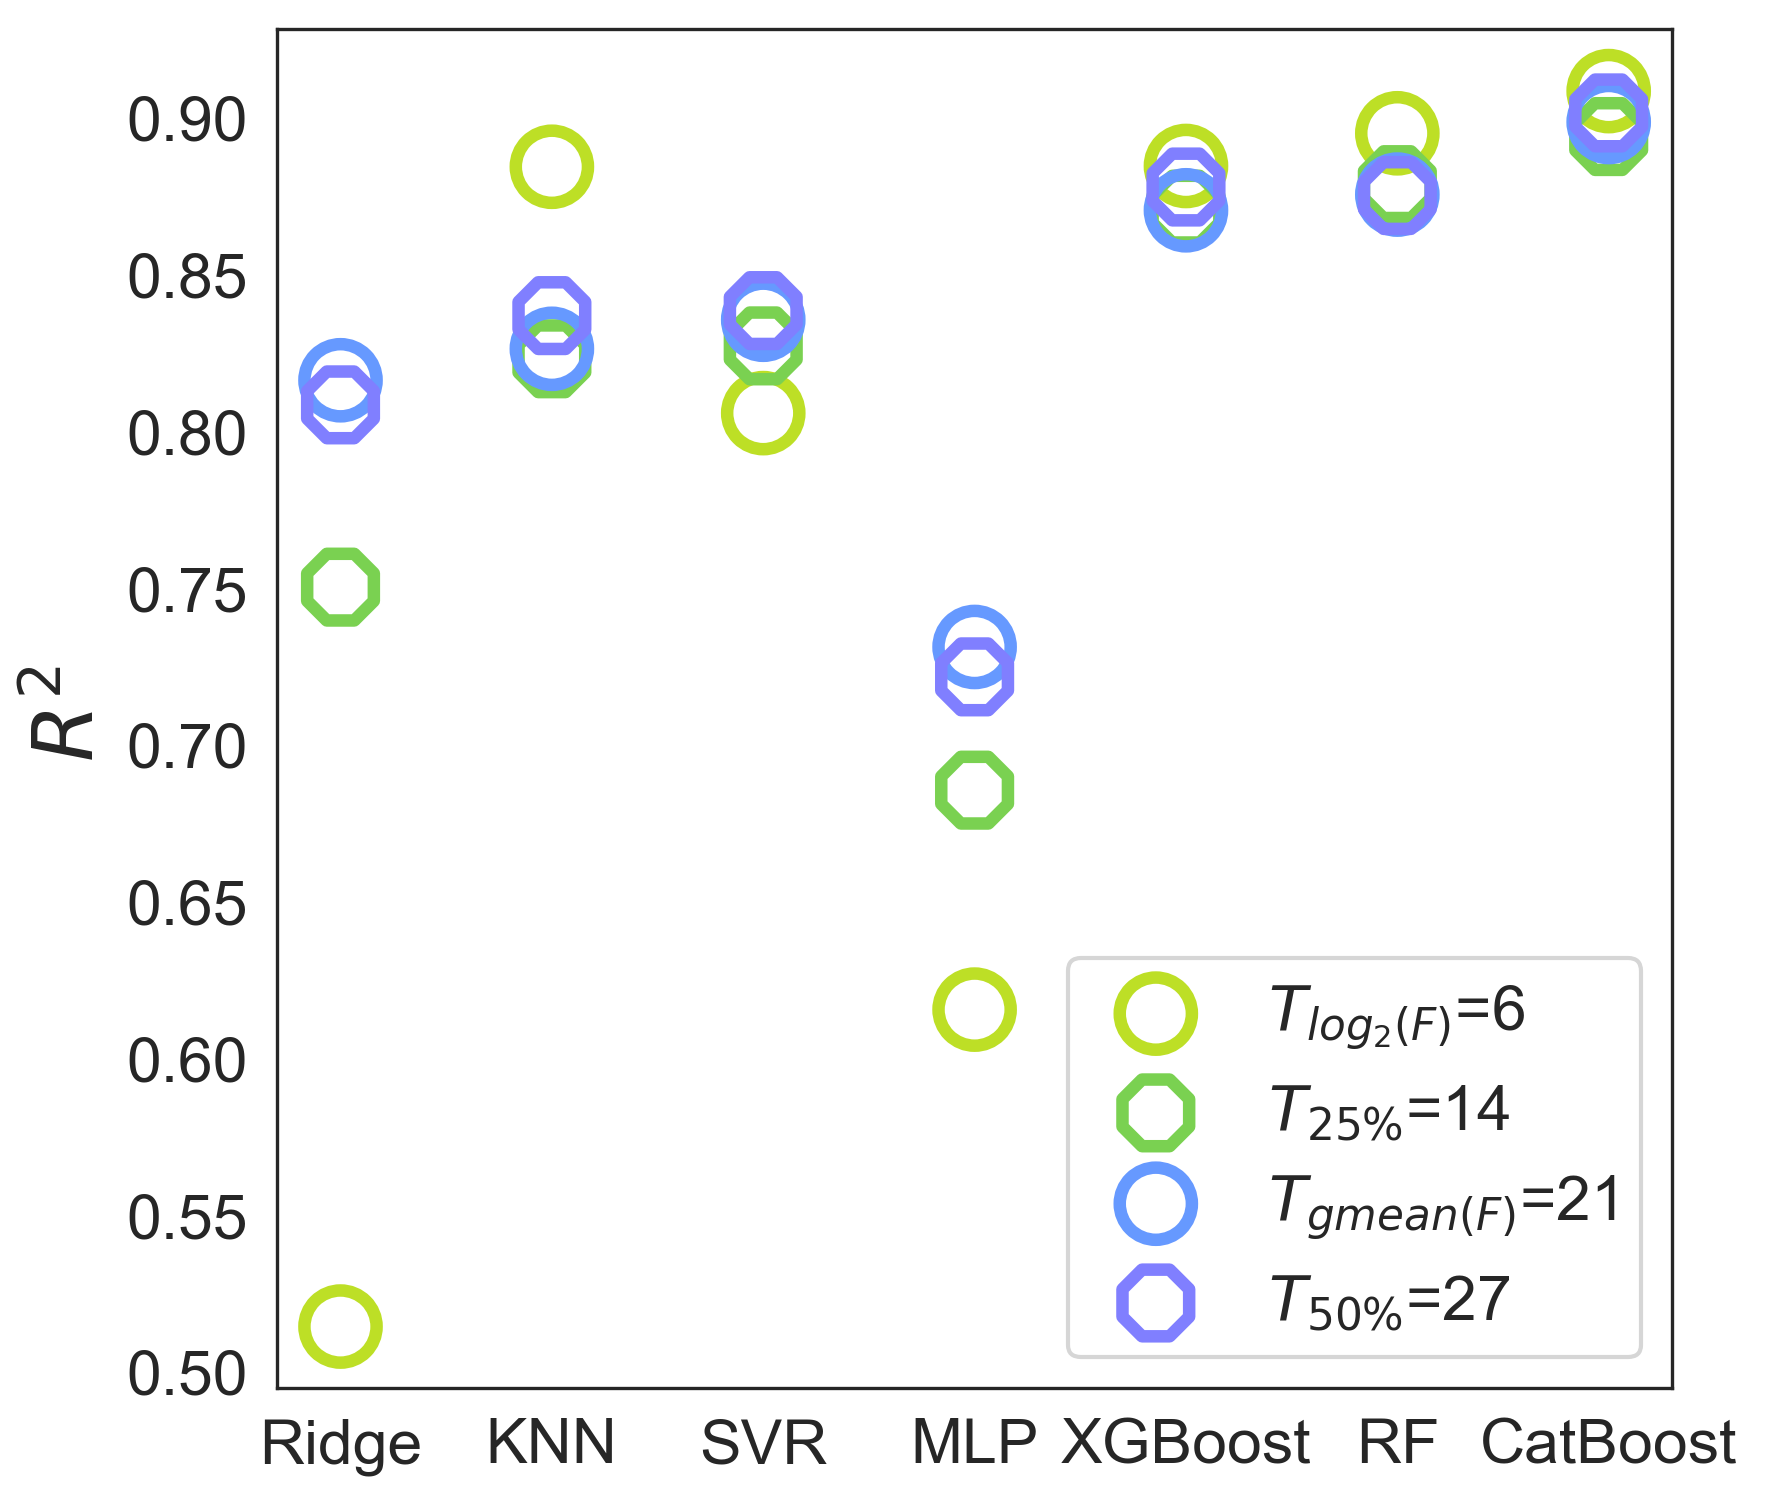

In [161]:
# 可视化

  
plt.figure(figsize=(6,6),dpi=300)
plt.rc('font',family='Times New Roman') 
sns.set_style("white") #设定整体背景风格
cm = plt.cm.get_cmap('viridis_r')
thr_sum=['thr_logn_cv10','thr_25_cv10','thr_geo_cv10','thr_50_cv10']
thr_=[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)]
#thr_=['thr_logn='+str(thr_logn),'thr_25='+str(thr_25),'thr_geo='+str(thr_geo),'thr_50='+str(thr_50)]
#colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.2),plt.cm.cool(0.3)]
#colors=['#f0c9cf','#93b5cf','#93d5dc','#83cbac']
colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.4),plt.cm.cool(0.5)]
#colors=['#44803F','#B4CF66','#FFEC5C','#FF5A33']
marker=['o','8','o','8']
P=['p1','p2','p3','p4']
for i in range(len(thr_sum)):
    P[i]=plt.scatter(data1_sum_cv10.loc[data1_sum_cv10['thr']==thr_sum[i],"models"]
                    ,data1_sum_cv10.loc[data1_sum_cv10['thr']==thr_sum[i],"cv10_r2"]
                    ,s=300
                    ,marker=marker[i]
                    ,c=''
                    ,edgecolors=colors[i]
                    ,linewidths=3
                    ,label=thr_[i]
               )
    print(P[i])
#plt.xlabel('Methods',fontsize=20) #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('$R^2$ ',fontsize=20) #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小
plt.legend(loc='lower right',fontsize=15)
#plt.legend(['p1','p2','p3','p4'],[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)],loc='lower right',fontsize=25)
plt.show()

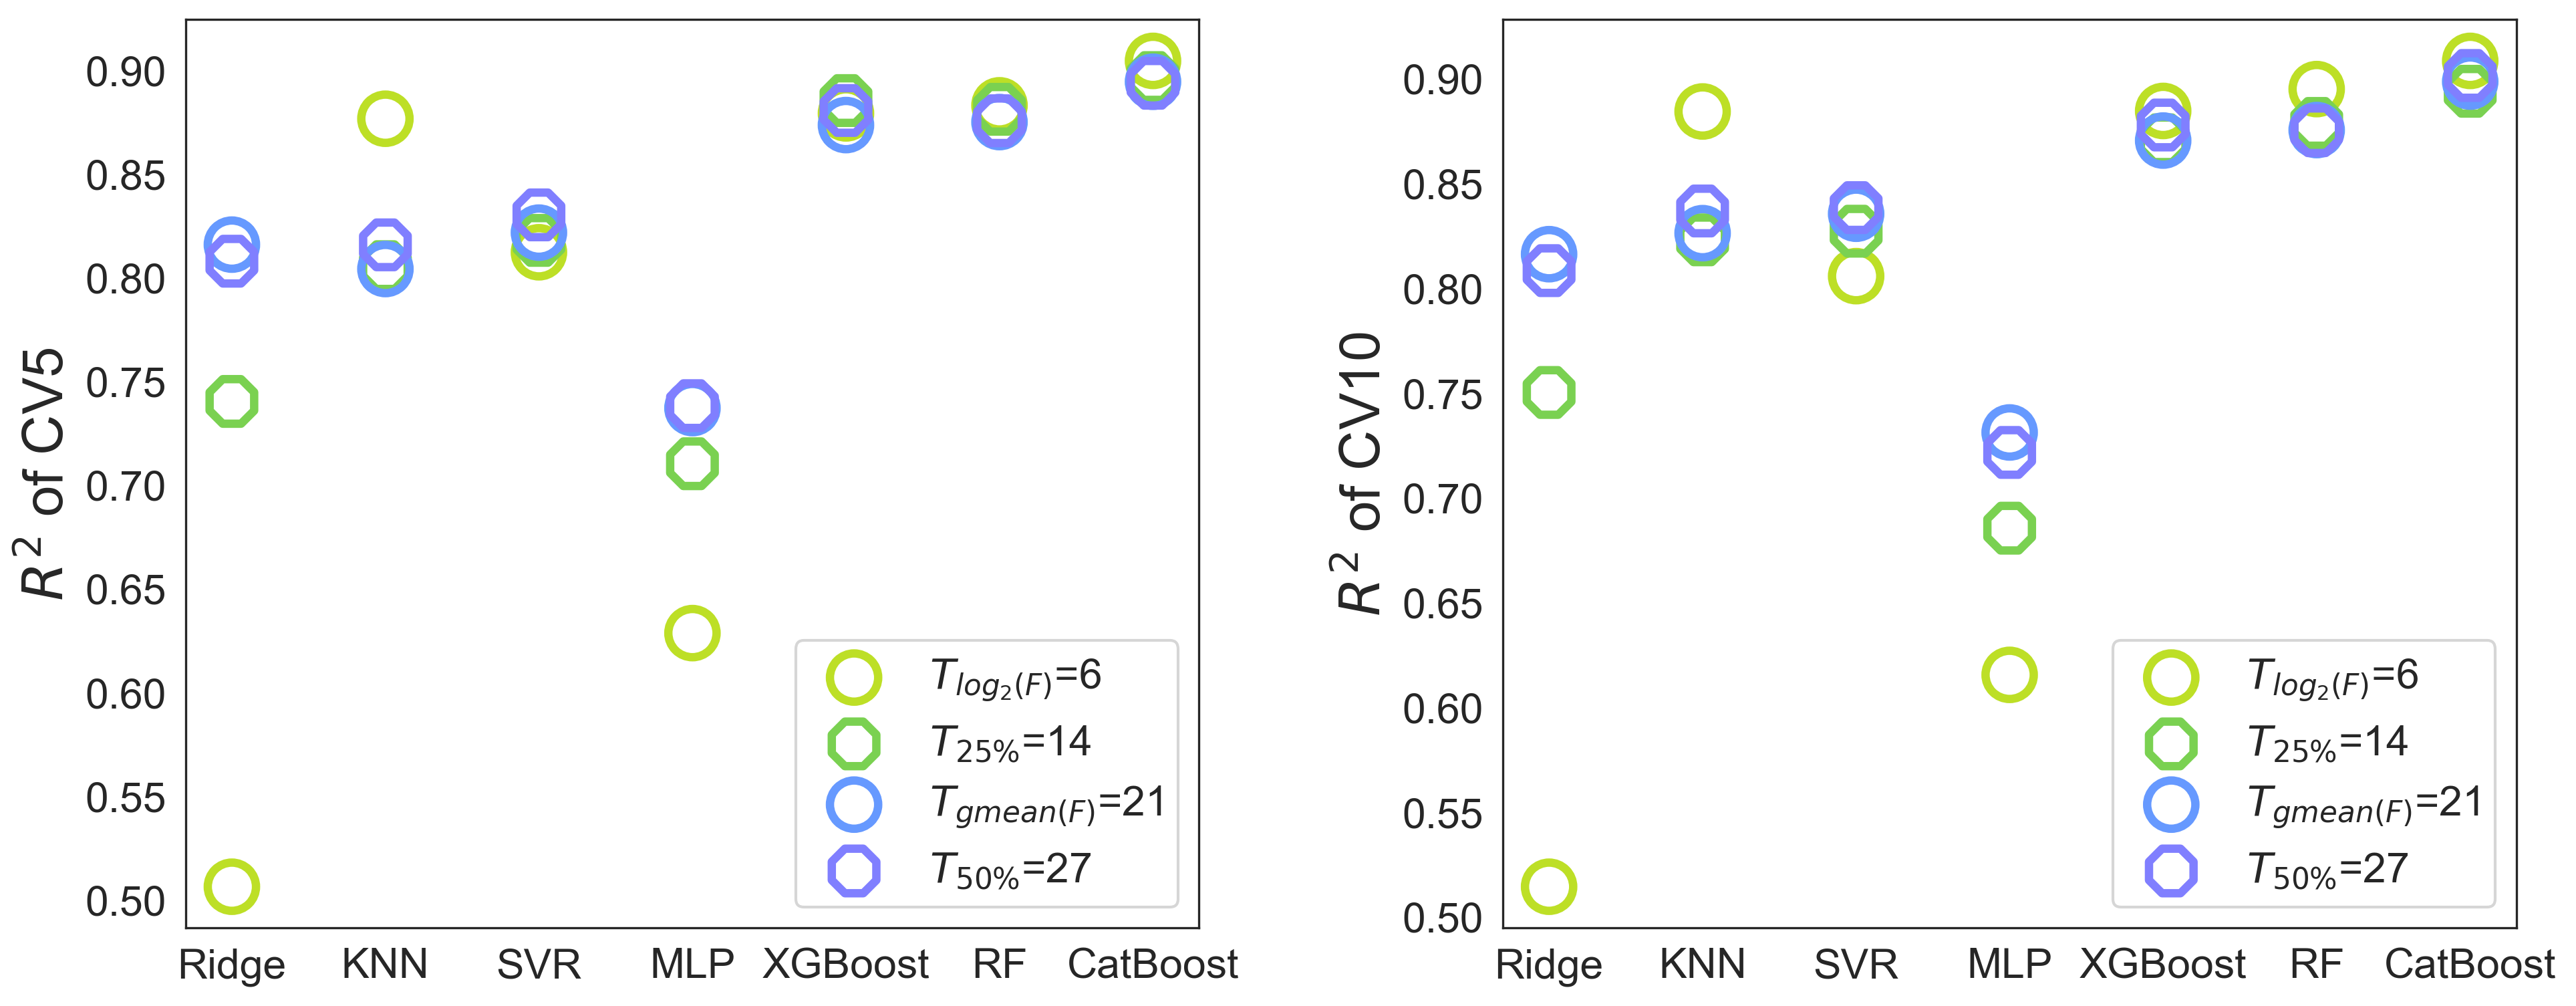

In [12]:
plt.figure(figsize=(15,6),dpi=300)
plt.subplot(1,2,1)
plt.rc('font',family='Times New Roman') 
sns.set_style("white") #设定整体背景风格
cm = plt.cm.get_cmap('viridis_r')
thr_sum=['thr_logn_cv5','thr_25_cv5','thr_geo_cv5','thr_50_cv5']
thr_=[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)]
#thr_=['thr_logn='+str(thr_logn),'thr_25='+str(thr_25),'thr_geo='+str(thr_geo),'thr_50='+str(thr_50)]
#colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.2),plt.cm.cool(0.3)]
#colors=['#f0c9cf','#93b5cf','#93d5dc','#83cbac']
colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.4),plt.cm.cool(0.5)]
#colors=['#44803F','#B4CF66','#FFEC5C','#FF5A33']
marker=['o','8','o','8']
P=['p1','p2','p3','p4']
for i in range(len(thr_sum)):
    P[i]=plt.scatter(data1_sum_cv5.loc[data1_sum_cv5['thr']==thr_sum[i],"models"]
                    ,data1_sum_cv5.loc[data1_sum_cv5['thr']==thr_sum[i],"cv5_r2"]
                    ,s=300
                    ,marker=marker[i]
                    ,c=''
                    ,edgecolors=colors[i]
                    ,linewidths=3
                    ,label=thr_[i]
               )
#plt.xlabel('Methods',fontsize=20) #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('$R^2$ '+'of CV5',fontsize=20) #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小
plt.legend(loc='lower right',fontsize=15)
#plt.legend(['p1','p2','p3','p4'],[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)],loc='lower right',fontsize=25)
#plt.show()

plt.subplot(1,2,2)
plt.rc('font',family='Times New Roman') 
sns.set_style("white") #设定整体背景风格
cm = plt.cm.get_cmap('viridis_r')
thr_sum=['thr_logn_cv10','thr_25_cv10','thr_geo_cv10','thr_50_cv10']
thr_=[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)]
#thr_=['thr_logn='+str(thr_logn),'thr_25='+str(thr_25),'thr_geo='+str(thr_geo),'thr_50='+str(thr_50)]
#colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.2),plt.cm.cool(0.3)]
#colors=['#f0c9cf','#93b5cf','#93d5dc','#83cbac']
colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.4),plt.cm.cool(0.5)]
#colors=['#44803F','#B4CF66','#FFEC5C','#FF5A33']
marker=['o','8','o','8']
P=['p1','p2','p3','p4']
for i in range(len(thr_sum)):
    P[i]=plt.scatter(data1_sum_cv10.loc[data1_sum_cv10['thr']==thr_sum[i],"models"]
                    ,data1_sum_cv10.loc[data1_sum_cv10['thr']==thr_sum[i],"cv10_r2"]
                    ,s=300
                    ,marker=marker[i]
                    ,c=''
                    ,edgecolors=colors[i]
                    ,linewidths=3
                    ,label=thr_[i]
               )
#plt.xlabel('Methods',fontsize=20) #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('$R^2$ '+'of CV10',fontsize=20) #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小
plt.legend(loc='lower right',fontsize=15)
#plt.legend(['p1','p2','p3','p4'],[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)],loc='lower right',fontsize=25)
#plt.show()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)


## 重复实验——集成最优结果（平衡精度和复杂度）

In [ ]:
根据可视化结果，平衡模型复杂度和精度，五折和十折均选择6个特征  模型

五折十折 a_best=0.1 logn 6
['Xa', 'Rm', 'Xr', 'Vm', 'VEC', 'Rc']
['Xa', 'Rm', 'Xr', 'Vm', 'VEC', 'Rc']

In [91]:
#验证最优特征子集
model=CatBoostRegressor(random_state=0,verbose=False)
x_train=X_train[['Xa', 'Rm', 'Xr', 'Vm', 'VEC', 'Rc']]
x_test=X_test[['Xa', 'Rm', 'Xr', 'Vm', 'VEC', 'Rc']]
model=model.fit(x_train,y_train) 
y_pred_test= model.predict(x_test)
test_r2_=round(metrics.r2_score(y_test, y_pred_test),6)# a=[] a=计算公式 a.append(a) 会报错

cv10= KFold(n_splits=10, shuffle = True,random_state=0)
y_pred_cv10 = cross_val_predict(model,x_train,y_train, cv=cv10)
cv10_r2_=round(metrics.r2_score(y_train, y_pred_cv10),6)
cv10_r2_,test_r2_

(0.908444, 0.881067)

In [8]:
data_hea=pd.read_csv('HEA_data.csv')
data_hea=data_hea.iloc[:,2:-1]
X=data_hea.iloc[:,1:]
y=data_hea.iloc[:,0]


X_logn_cut=X[['Xa', 'Rm', 'Xr', 'Vm', 'VEC', 'Rc']]
data_logn_cut=pd.concat([pd.DataFrame(y),X_logn_cut],axis=1)
features=data_logn_cut.columns[1:]
target=data_logn_cut.columns[0]
num_bins = round(1 + np.log2(data_logn_cut.shape[0]))
model=CatBoostRegressor(verbose=False,random_state=0)

df_result = pd.DataFrame()
for rs in range(0,300):
    print(f'========{rs}===========')
    X_train,X_test,y_train,y_test = stratifed_sample_cut(data_logn_cut,target,features,groups=num_bins,train_split_ratio=0.8,random_state=rs)
    model=model.fit(X_train,y_train)
    y_pred_test= model.predict(X_test)
    test_r2 = round(metrics.r2_score(y_test, y_pred_test),6)
    test_r=round(np.corrcoef(y_test, y_pred_test)[0][1],6)
    test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),6)
    
    cv5 = KFold(n_splits=5, shuffle = True,random_state=rs)
    
    y_pred_cv5 = cross_val_predict(model,X_train,y_train, cv=cv5)
    cv5_r2=round(metrics.r2_score(y_train, y_pred_cv5),6)
    cv5_r=round(np.corrcoef(y_train, y_pred_cv5)[0][1],6)
    cv5_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv5)),6)
    
    cv10= KFold(n_splits=10, shuffle = True,random_state=rs)
    y_pred_cv10 = cross_val_predict(model,X_train,y_train, cv=cv10)
    cv10_r2=round(metrics.r2_score(y_train, y_pred_cv10),6)
    cv10_r=round(np.corrcoef(y_train, y_pred_cv10)[0][1],6)
    cv10_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv10)),6)
    
    #loo=LeaveOneOut()
    #y_pred_loo = cross_val_predict(algo(random_state=0,verbose=False),X_train,y_train, cv=loo)
    #loo_r2=round(metrics.r2_score(y_train, y_pred_loo),6)
    #loo_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_loo)),6)
    
    dict_result = {
        'rs': [rs],  
        'cv5_r2':[cv5_r2],
        'cv5_r':[cv5_r],
        'cv5_rmse':[cv5_rmse],
        'cv10_r2':[cv10_r2],
        'cv10_r':[cv10_r],
        'cv10_rmse':[cv10_rmse],
        'test r2': [test_r2], 
        'test r':[test_r],
        'test rmse': [test_rmse],
        }
    df_result=df_result.append(pd.DataFrame(dict_result))
df_result_micshap=df_result
df_result_mean_micshap=pd.DataFrame(df_result_micshap.mean()).T
df_result_mean_micshap['rs']=df_result_micshap.shape[0]
df_result_micshap

========0===========
42
14
10
14
20
10
13
6
========1===========
42
14
10
14
20
10
13
6
========2===========
42
14
10
14
20
10
13
6
========3===========
42
14
10
14
20
10
13
6
========4===========
42
14
10
14
20
10
13
6
========5===========
42
14
10
14
20
10
13
6
========6===========
42
14
10
14
20
10
13
6
========7===========
42
14
10
14
20
10
13
6
========8===========
42
14
10
14
20
10
13
6
========9===========
42
14
10
14
20
10
13
6
========10===========
42
14
10
14
20
10
13
6
========11===========
42
14
10
14
20
10
13
6
========12===========
42
14
10
14
20
10
13
6
========13===========
42
14
10
14
20
10
13
6
========14===========
42
14
10
14
20
10
13
6
========15===========
42
14
10
14
20
10
13
6
========16===========
42
14
10
14
20
10
13
6
========17===========
42
14
10
14
20
10
13
6
========18===========
42
14
10
14
20
10
13
6
========19===========
42
14
10
14
20
10
13
6
========20===========
42
14
10
14
20
10
13
6
========21===========
42
14
10
14
20
10
13
6
========22==========

========181===========
42
14
10
14
20
10
13
6
========182===========
42
14
10
14
20
10
13
6
========183===========
42
14
10
14
20
10
13
6
========184===========
42
14
10
14
20
10
13
6
========185===========
42
14
10
14
20
10
13
6
========186===========
42
14
10
14
20
10
13
6
========187===========
42
14
10
14
20
10
13
6
========188===========
42
14
10
14
20
10
13
6
========189===========
42
14
10
14
20
10
13
6
========190===========
42
14
10
14
20
10
13
6
========191===========
42
14
10
14
20
10
13
6
========192===========
42
14
10
14
20
10
13
6
========193===========
42
14
10
14
20
10
13
6
========194===========
42
14
10
14
20
10
13
6
========195===========
42
14
10
14
20
10
13
6
========196===========
42
14
10
14
20
10
13
6
========197===========
42
14
10
14
20
10
13
6
========198===========
42
14
10
14
20
10
13
6
========199===========
42
14
10
14
20
10
13
6
========200===========
42
14
10
14
20
10
13
6
========201===========
42
14
10
14
20
10
13
6
========202===========
42
14
10
14

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.904503,0.951491,510.986046,0.908444,0.953212,500.330861,0.881067,0.939950,545.465142
0,1,0.905013,0.951742,513.827333,0.910074,0.954102,499.950551,0.855818,0.935973,579.851348
0,2,0.894643,0.945912,540.137822,0.904153,0.951034,515.183213,0.858334,0.927331,579.767446
0,3,0.885606,0.941309,554.507605,0.896415,0.947052,527.662219,0.908215,0.956684,496.923015
0,4,0.886324,0.941538,555.211712,0.885674,0.941333,556.797498,0.941345,0.970311,390.300899
...,...,...,...,...,...,...,...,...,...,...
0,295,0.899028,0.948704,521.482085,0.901038,0.949535,516.266180,0.841277,0.927359,650.890187
0,296,0.938755,0.968948,410.951667,0.937480,0.968288,415.209787,0.795208,0.900886,703.041708
0,297,0.885194,0.941668,562.994664,0.887895,0.942540,556.332758,0.950261,0.976104,345.651084
0,298,0.909967,0.953968,497.193970,0.913567,0.955862,487.154724,0.841719,0.922693,623.183589


In [9]:
df_result_micshap

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.904503,0.951491,510.986046,0.908444,0.953212,500.330861,0.881067,0.939950,545.465142
0,1,0.905013,0.951742,513.827333,0.910074,0.954102,499.950551,0.855818,0.935973,579.851348
0,2,0.894643,0.945912,540.137822,0.904153,0.951034,515.183213,0.858334,0.927331,579.767446
0,3,0.885606,0.941309,554.507605,0.896415,0.947052,527.662219,0.908215,0.956684,496.923015
0,4,0.886324,0.941538,555.211712,0.885674,0.941333,556.797498,0.941345,0.970311,390.300899
...,...,...,...,...,...,...,...,...,...,...
0,295,0.899028,0.948704,521.482085,0.901038,0.949535,516.266180,0.841277,0.927359,650.890187
0,296,0.938755,0.968948,410.951667,0.937480,0.968288,415.209787,0.795208,0.900886,703.041708
0,297,0.885194,0.941668,562.994664,0.887895,0.942540,556.332758,0.950261,0.976104,345.651084
0,298,0.909967,0.953968,497.193970,0.913567,0.955862,487.154724,0.841719,0.922693,623.183589


In [10]:
df_result_micshap.to_csv('20221026df_result_micshap.csv')

In [11]:
df_result_mean_micshap

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,300,0.896747,0.947218,530.411381,0.899562,0.948628,523.202054,0.889222,0.946464,519.680355


### 基特征选择方法的比较

In [12]:
data_hea=pd.read_csv('HEA_data.csv')
data_hea=data_hea.iloc[:,2:-1]
X=data_hea.iloc[:,1:]
y=data_hea.iloc[:,0]

num_bins = round(1 + np.log2(data_hea.shape[0]))# 向下取整修改为四舍五入
features=data_hea.columns[1:]
target=data_hea.columns[0]
X_train,X_test,y_train,y_test= stratifed_sample_cut(data_hea,target,features,groups=num_bins,train_split_ratio=0.8,random_state=0)


FN_new=6
data_mrmr=pd.concat([pd.DataFrame(y_train,columns=[target]),pd.DataFrame(X_train)],axis=1)
mRMR_features=pymrmr.mRMR(data_mrmr,'MID',FN_new)# MID 互信息差

f_score, pvalues_f = f_regression(X_train,y_train)
F_score=round(pd.DataFrame(list(zip(X_train.columns,f_score)),columns=['Features','Score_F']),6)
F_features=list(F_score.sort_values(by="Score_F",ascending=False)['Features'].values[:FN_new])

dcor_score=[]
for i in range(X_train.shape[1]):
    dcor_=dcor.distance_correlation(X_train.iloc[:,i], y_train).round(6)
    dcor_score.append(dcor_) 
Dcor_score=pd.DataFrame(list(zip(X_train.columns,dcor_score)),columns=['Features','Score_Dcor'])
Dcor_features=list(Dcor_score.sort_values(by="Score_Dcor",ascending=False)['Features'].values[:FN_new])

RF=RandomForestRegressor(random_state=0)
rfe=RFE(RF,n_features_to_select=FN_new,step=1)
selector=rfe.fit(X_train,y_train)
RFE_features=X_train.columns[rfe.get_support()]

# 基于RF 的嵌入式特征选择
RF=RandomForestRegressor(random_state=0)
RF.fit(X_train,y_train)
rffi_score=round(pd.DataFrame(list(zip(X_train.columns,RF.feature_importances_)),columns=['Features','Score_rffi']),6)
RFFI_features=list(rffi_score.sort_values(by="Score_rffi",ascending=False)['Features'].values[:FN_new])
mRMR_features,F_features,Dcor_features,RFE_features

42
14
10
14
20
10
13
6


(['Ri', 'ΔVm', 'δXr', 'E', 'e/a', 'δHc'],
 ['δVm', 'δRc', 'δG', 'δE', 'ΔRc', 'δK'],
 ['δRc', 'δG', 'δVm', 'δE', 'δK', 'ΔRc'],
 Index(['Rm', 'Vm', 'VEC', 'Xa', 'δG', 'ΔG'], dtype='object'))

#### mRMR

In [14]:

data_mRMR=pd.concat([pd.DataFrame(y),X[mRMR_features]],axis=1)
target=data_mRMR.columns[0]
features=data_mRMR.columns[1:]
num_bins = round(1 + np.log2(data_mRMR.shape[0]))
model=CatBoostRegressor(verbose=False,random_state=0)


df_result = pd.DataFrame()
for rs in range(0,300):
    print(f'========{rs}===========')
    X_train,X_test,y_train,y_test = stratifed_sample_cut(data_mRMR,target,features,groups=num_bins,train_split_ratio=0.8,random_state=rs)
    model=model.fit(X_train,y_train)
    y_pred_test= model.predict(X_test)
    test_r2 = round(metrics.r2_score(y_test, y_pred_test),6)
    test_r=round(np.corrcoef(y_test, y_pred_test)[0][1],6)
    test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),6)
    
    cv5 = KFold(n_splits=5, shuffle = True,random_state=rs)
    
    y_pred_cv5 = cross_val_predict(model,X_train,y_train, cv=cv5)
    cv5_r2=round(metrics.r2_score(y_train, y_pred_cv5),6)
    cv5_r=round(np.corrcoef(y_train, y_pred_cv5)[0][1],6)
    cv5_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv5)),6)
    
    cv10= KFold(n_splits=10, shuffle = True,random_state=rs)
    y_pred_cv10 = cross_val_predict(model,X_train,y_train, cv=cv10)
    cv10_r2=round(metrics.r2_score(y_train, y_pred_cv10),6)
    cv10_r=round(np.corrcoef(y_train, y_pred_cv10)[0][1],6)
    cv10_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv10)),6)
    
    #loo=LeaveOneOut()
    #y_pred_loo = cross_val_predict(algo(random_state=0,verbose=False),X_train,y_train, cv=loo)
    #loo_r2=round(metrics.r2_score(y_train, y_pred_loo),6)
    #loo_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_loo)),6)
    
    dict_result = {
        'rs': [rs],  
        'cv5_r2':[cv5_r2],
        'cv5_r':[cv5_r],
        'cv5_rmse':[cv5_rmse],
        'cv10_r2':[cv10_r2],
        'cv10_r':[cv10_r],
        'cv10_rmse':[cv10_rmse],
        'test r2': [test_r2],
        'test r':[test_r],
        'test rmse': [test_rmse],
        }
    df_result=df_result.append(pd.DataFrame(dict_result))
df_result_mrmr=df_result   
df_result_mean_mrmr=pd.DataFrame(df_result_mrmr.mean()).T
df_result_mean_mrmr['rs']=df_result_mrmr.shape[0]
df_result_mrmr

========0===========
42
14
10
14
20
10
13
6
========1===========
42
14
10
14
20
10
13
6
========2===========
42
14
10
14
20
10
13
6
========3===========
42
14
10
14
20
10
13
6
========4===========
42
14
10
14
20
10
13
6
========5===========
42
14
10
14
20
10
13
6
========6===========
42
14
10
14
20
10
13
6
========7===========
42
14
10
14
20
10
13
6
========8===========
42
14
10
14
20
10
13
6
========9===========
42
14
10
14
20
10
13
6
========10===========
42
14
10
14
20
10
13
6
========11===========
42
14
10
14
20
10
13
6
========12===========
42
14
10
14
20
10
13
6
========13===========
42
14
10
14
20
10
13
6
========14===========
42
14
10
14
20
10
13
6
========15===========
42
14
10
14
20
10
13
6
========16===========
42
14
10
14
20
10
13
6
========17===========
42
14
10
14
20
10
13
6
========18===========
42
14
10
14
20
10
13
6
========19===========
42
14
10
14
20
10
13
6
========20===========
42
14
10
14
20
10
13
6
========21===========
42
14
10
14
20
10
13
6
========22==========

========181===========
42
14
10
14
20
10
13
6
========182===========
42
14
10
14
20
10
13
6
========183===========
42
14
10
14
20
10
13
6
========184===========
42
14
10
14
20
10
13
6
========185===========
42
14
10
14
20
10
13
6
========186===========
42
14
10
14
20
10
13
6
========187===========
42
14
10
14
20
10
13
6
========188===========
42
14
10
14
20
10
13
6
========189===========
42
14
10
14
20
10
13
6
========190===========
42
14
10
14
20
10
13
6
========191===========
42
14
10
14
20
10
13
6
========192===========
42
14
10
14
20
10
13
6
========193===========
42
14
10
14
20
10
13
6
========194===========
42
14
10
14
20
10
13
6
========195===========
42
14
10
14
20
10
13
6
========196===========
42
14
10
14
20
10
13
6
========197===========
42
14
10
14
20
10
13
6
========198===========
42
14
10
14
20
10
13
6
========199===========
42
14
10
14
20
10
13
6
========200===========
42
14
10
14
20
10
13
6
========201===========
42
14
10
14
20
10
13
6
========202===========
42
14
10
14

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.764725,0.874493,802.053004,0.758736,0.871160,812.196264,0.569303,0.778307,1038.009424
0,1,0.777272,0.881999,786.814816,0.771387,0.878378,797.141769,0.693888,0.837114,844.892514
0,2,0.742758,0.862683,844.004659,0.734138,0.857946,858.028599,0.712646,0.847124,825.713872
0,3,0.696302,0.836052,903.499358,0.721481,0.850898,865.234809,0.709966,0.844213,883.339023
0,4,0.741775,0.861550,836.804402,0.731565,0.855515,853.186370,0.749342,0.884414,806.840883
...,...,...,...,...,...,...,...,...,...,...
0,295,0.849614,0.922285,636.417086,0.852271,0.923588,630.771835,0.397338,0.689384,1268.306817
0,296,0.824390,0.908422,695.875178,0.806663,0.898465,730.154012,0.699907,0.843817,851.045376
0,297,0.753829,0.868357,824.406109,0.761050,0.872423,812.224725,0.736999,0.862643,794.819899
0,298,0.799858,0.894362,741.302299,0.797096,0.892814,746.399864,0.634250,0.810992,947.314404


In [15]:
df_result_mrmr

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.764725,0.874493,802.053004,0.758736,0.871160,812.196264,0.569303,0.778307,1038.009424
0,1,0.777272,0.881999,786.814816,0.771387,0.878378,797.141769,0.693888,0.837114,844.892514
0,2,0.742758,0.862683,844.004659,0.734138,0.857946,858.028599,0.712646,0.847124,825.713872
0,3,0.696302,0.836052,903.499358,0.721481,0.850898,865.234809,0.709966,0.844213,883.339023
0,4,0.741775,0.861550,836.804402,0.731565,0.855515,853.186370,0.749342,0.884414,806.840883
...,...,...,...,...,...,...,...,...,...,...
0,295,0.849614,0.922285,636.417086,0.852271,0.923588,630.771835,0.397338,0.689384,1268.306817
0,296,0.824390,0.908422,695.875178,0.806663,0.898465,730.154012,0.699907,0.843817,851.045376
0,297,0.753829,0.868357,824.406109,0.761050,0.872423,812.224725,0.736999,0.862643,794.819899
0,298,0.799858,0.894362,741.302299,0.797096,0.892814,746.399864,0.634250,0.810992,947.314404


In [16]:
df_result_mrmr.to_csv('20221026df_result_mrmr.csv')

In [17]:
df_result_mean_mrmr

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,300,0.742785,0.86233,836.015022,0.749167,0.865847,825.647458,0.727811,0.860842,804.061116


#### F检验

In [18]:
data_F=pd.concat([pd.DataFrame(y),X[F_features]],axis=1)
features=data_F.columns[1:]
target=data_F.columns[0]
num_bins = round(1 + np.log2(data_F.shape[0]))
model=CatBoostRegressor(verbose=False,random_state=0)

df_result = pd.DataFrame()
for rs in range(0,300):
    print(f'========{rs}===========')
    X_train,X_test,y_train,y_test = stratifed_sample_cut(data_F,target,features,groups=num_bins,train_split_ratio=0.8,random_state=rs)
    model=model.fit(X_train,y_train)
    y_pred_test= model.predict(X_test)
    test_r2 = round(metrics.r2_score(y_test, y_pred_test),6)
    test_r=round(np.corrcoef(y_test, y_pred_test)[0][1],6)
    test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),6)
    
    cv5 = KFold(n_splits=5, shuffle = True,random_state=rs)
    
    y_pred_cv5 = cross_val_predict(model,X_train,y_train, cv=cv5)
    cv5_r2=round(metrics.r2_score(y_train, y_pred_cv5),6)
    cv5_r=round(np.corrcoef(y_train, y_pred_cv5)[0][1],6)
    cv5_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv5)),6)
    
    cv10= KFold(n_splits=10, shuffle = True,random_state=rs)
    y_pred_cv10 = cross_val_predict(model,X_train,y_train, cv=cv10)
    cv10_r2=round(metrics.r2_score(y_train, y_pred_cv10),6)
    cv10_r=round(np.corrcoef(y_train, y_pred_cv10)[0][1],6)
    cv10_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv10)),6)
    
    #loo=LeaveOneOut()
    #y_pred_loo = cross_val_predict(algo(random_state=0,verbose=False),X_train,y_train, cv=loo)
    #loo_r2=round(metrics.r2_score(y_train, y_pred_loo),6)
    #loo_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_loo)),6)
    
    dict_result = {
        'rs': [rs],  
        'cv5_r2':[cv5_r2],
        'cv5_r':[cv5_r],
        'cv5_rmse':[cv5_rmse],
        'cv10_r2':[cv10_r2],
        'cv10_r':[cv10_r],
        'cv10_rmse':[cv10_rmse],
        'test r2': [test_r2], 
        'test r':[test_r],
        'test rmse': [test_rmse],
        }
    df_result=df_result.append(pd.DataFrame(dict_result))
    
df_result_f=df_result   
df_result_mean_f=pd.DataFrame(df_result_f.mean()).T
df_result_mean_f['rs']=df_result_f.shape[0]
df_result_f

========0===========
42
14
10
14
20
10
13
6
========1===========
42
14
10
14
20
10
13
6
========2===========
42
14
10
14
20
10
13
6
========3===========
42
14
10
14
20
10
13
6
========4===========
42
14
10
14
20
10
13
6
========5===========
42
14
10
14
20
10
13
6
========6===========
42
14
10
14
20
10
13
6
========7===========
42
14
10
14
20
10
13
6
========8===========
42
14
10
14
20
10
13
6
========9===========
42
14
10
14
20
10
13
6
========10===========
42
14
10
14
20
10
13
6
========11===========
42
14
10
14
20
10
13
6
========12===========
42
14
10
14
20
10
13
6
========13===========
42
14
10
14
20
10
13
6
========14===========
42
14
10
14
20
10
13
6
========15===========
42
14
10
14
20
10
13
6
========16===========
42
14
10
14
20
10
13
6
========17===========
42
14
10
14
20
10
13
6
========18===========
42
14
10
14
20
10
13
6
========19===========
42
14
10
14
20
10
13
6
========20===========
42
14
10
14
20
10
13
6
========21===========
42
14
10
14
20
10
13
6
========22==========

========181===========
42
14
10
14
20
10
13
6
========182===========
42
14
10
14
20
10
13
6
========183===========
42
14
10
14
20
10
13
6
========184===========
42
14
10
14
20
10
13
6
========185===========
42
14
10
14
20
10
13
6
========186===========
42
14
10
14
20
10
13
6
========187===========
42
14
10
14
20
10
13
6
========188===========
42
14
10
14
20
10
13
6
========189===========
42
14
10
14
20
10
13
6
========190===========
42
14
10
14
20
10
13
6
========191===========
42
14
10
14
20
10
13
6
========192===========
42
14
10
14
20
10
13
6
========193===========
42
14
10
14
20
10
13
6
========194===========
42
14
10
14
20
10
13
6
========195===========
42
14
10
14
20
10
13
6
========196===========
42
14
10
14
20
10
13
6
========197===========
42
14
10
14
20
10
13
6
========198===========
42
14
10
14
20
10
13
6
========199===========
42
14
10
14
20
10
13
6
========200===========
42
14
10
14
20
10
13
6
========201===========
42
14
10
14
20
10
13
6
========202===========
42
14
10
14

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.771571,0.879148,790.297124,0.773681,0.880532,786.639101,0.570533,0.778146,1036.526011
0,1,0.739224,0.860460,851.372435,0.706200,0.841902,903.673026,0.765877,0.876542,738.896433
0,2,0.724670,0.853402,873.172997,0.729732,0.856901,865.108999,0.807266,0.903237,676.238455
0,3,0.669308,0.819169,942.798694,0.690247,0.831651,912.461007,0.840789,0.917616,654.470545
0,4,0.691760,0.833369,914.258461,0.695602,0.835087,908.542239,0.828608,0.919569,667.180102
...,...,...,...,...,...,...,...,...,...,...
0,295,0.848619,0.921535,638.519990,0.862868,0.929010,607.727586,0.251231,0.632771,1413.713572
0,296,0.753254,0.869201,824.862261,0.764592,0.875387,805.688719,0.521613,0.731873,1074.520112
0,297,0.738385,0.860123,849.872530,0.735049,0.858308,855.274320,0.685357,0.831515,869.359050
0,298,0.771058,0.878576,792.845428,0.774043,0.880390,787.660621,0.542519,0.760153,1059.470118


In [19]:
df_result_f

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.771571,0.879148,790.297124,0.773681,0.880532,786.639101,0.570533,0.778146,1036.526011
0,1,0.739224,0.860460,851.372435,0.706200,0.841902,903.673026,0.765877,0.876542,738.896433
0,2,0.724670,0.853402,873.172997,0.729732,0.856901,865.108999,0.807266,0.903237,676.238455
0,3,0.669308,0.819169,942.798694,0.690247,0.831651,912.461007,0.840789,0.917616,654.470545
0,4,0.691760,0.833369,914.258461,0.695602,0.835087,908.542239,0.828608,0.919569,667.180102
...,...,...,...,...,...,...,...,...,...,...
0,295,0.848619,0.921535,638.519990,0.862868,0.929010,607.727586,0.251231,0.632771,1413.713572
0,296,0.753254,0.869201,824.862261,0.764592,0.875387,805.688719,0.521613,0.731873,1074.520112
0,297,0.738385,0.860123,849.872530,0.735049,0.858308,855.274320,0.685357,0.831515,869.359050
0,298,0.771058,0.878576,792.845428,0.774043,0.880390,787.660621,0.542519,0.760153,1059.470118


In [20]:
df_result_f.to_csv('20221026df_result_f.csv')

In [21]:
df_result_mean_f

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,300,0.720074,0.849984,872.029002,0.726816,0.853761,861.994866,0.708545,0.851916,833.129207


#### 距离相关系数

In [22]:
data_Dcor=pd.concat([pd.DataFrame(y),X[Dcor_features]],axis=1)
features=data_Dcor.columns[1:]
target=data_Dcor.columns[0]
num_bins = round(1 + np.log2(data_Dcor.shape[0]))
model=CatBoostRegressor(verbose=False,random_state=0)


df_result = pd.DataFrame()
for rs in range(0,300):
    print(f'========{rs}===========')
    X_train,X_test,y_train,y_test = stratifed_sample_cut(data_Dcor,target,features,groups=num_bins,train_split_ratio=0.8,random_state=rs)
    model=model.fit(X_train,y_train)
    y_pred_test= model.predict(X_test)
    test_r2 = round(metrics.r2_score(y_test, y_pred_test),6)
    test_r=round(np.corrcoef(y_test, y_pred_test)[0][1],6)
    test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),6)
    
    cv5 = KFold(n_splits=5, shuffle = True,random_state=rs)
    
    y_pred_cv5 = cross_val_predict(model,X_train,y_train, cv=cv5)
    cv5_r2=round(metrics.r2_score(y_train, y_pred_cv5),6)
    cv5_r=round(np.corrcoef(y_train, y_pred_cv5)[0][1],6)
    cv5_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv5)),6)
    
    cv10= KFold(n_splits=10, shuffle = True,random_state=rs)
    y_pred_cv10 = cross_val_predict(model,X_train,y_train, cv=cv10)
    cv10_r2=round(metrics.r2_score(y_train, y_pred_cv10),6)
    cv10_r=round(np.corrcoef(y_train, y_pred_cv10)[0][1],6)
    cv10_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv10)),6)
    
    #loo=LeaveOneOut()
    #y_pred_loo = cross_val_predict(algo(random_state=0,verbose=False),X_train,y_train, cv=loo)
    #loo_r2=round(metrics.r2_score(y_train, y_pred_loo),6)
    #loo_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_loo)),6)
    
    dict_result = {
        'rs': [rs],  
        'cv5_r2':[cv5_r2],
        'cv5_r':[cv5_r],
        'cv5_rmse':[cv5_rmse],
        'cv10_r2':[cv10_r2],
        'cv10_r':[cv10_r],
        'cv10_rmse':[cv10_rmse],
        'test r2': [test_r2],
        'test r':[test_r],
        'test rmse': [test_rmse],
        }
    df_result=df_result.append(pd.DataFrame(dict_result))
    
df_result_dcor=df_result   
df_result_mean_dcor=pd.DataFrame(df_result_dcor.mean()).T
df_result_mean_dcor['rs']=df_result_dcor.shape[0]
df_result_dcor

========0===========
42
14
10
14
20
10
13
6
========1===========
42
14
10
14
20
10
13
6
========2===========
42
14
10
14
20
10
13
6
========3===========
42
14
10
14
20
10
13
6
========4===========
42
14
10
14
20
10
13
6
========5===========
42
14
10
14
20
10
13
6
========6===========
42
14
10
14
20
10
13
6
========7===========
42
14
10
14
20
10
13
6
========8===========
42
14
10
14
20
10
13
6
========9===========
42
14
10
14
20
10
13
6
========10===========
42
14
10
14
20
10
13
6
========11===========
42
14
10
14
20
10
13
6
========12===========
42
14
10
14
20
10
13
6
========13===========
42
14
10
14
20
10
13
6
========14===========
42
14
10
14
20
10
13
6
========15===========
42
14
10
14
20
10
13
6
========16===========
42
14
10
14
20
10
13
6
========17===========
42
14
10
14
20
10
13
6
========18===========
42
14
10
14
20
10
13
6
========19===========
42
14
10
14
20
10
13
6
========20===========
42
14
10
14
20
10
13
6
========21===========
42
14
10
14
20
10
13
6
========22==========

========181===========
42
14
10
14
20
10
13
6
========182===========
42
14
10
14
20
10
13
6
========183===========
42
14
10
14
20
10
13
6
========184===========
42
14
10
14
20
10
13
6
========185===========
42
14
10
14
20
10
13
6
========186===========
42
14
10
14
20
10
13
6
========187===========
42
14
10
14
20
10
13
6
========188===========
42
14
10
14
20
10
13
6
========189===========
42
14
10
14
20
10
13
6
========190===========
42
14
10
14
20
10
13
6
========191===========
42
14
10
14
20
10
13
6
========192===========
42
14
10
14
20
10
13
6
========193===========
42
14
10
14
20
10
13
6
========194===========
42
14
10
14
20
10
13
6
========195===========
42
14
10
14
20
10
13
6
========196===========
42
14
10
14
20
10
13
6
========197===========
42
14
10
14
20
10
13
6
========198===========
42
14
10
14
20
10
13
6
========199===========
42
14
10
14
20
10
13
6
========200===========
42
14
10
14
20
10
13
6
========201===========
42
14
10
14
20
10
13
6
========202===========
42
14
10
14

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.772940,0.880090,787.926607,0.773262,0.880463,787.367264,0.549940,0.768028,1061.085835
0,1,0.732561,0.856377,862.179432,0.719215,0.848780,883.430752,0.756953,0.871192,752.845665
0,2,0.724527,0.852940,873.399230,0.727206,0.855316,869.142661,0.798437,0.900508,691.555230
0,3,0.659797,0.813493,956.259962,0.679303,0.825722,928.441080,0.834913,0.914410,666.437295
0,4,0.694603,0.834896,910.032941,0.695774,0.835159,908.286070,0.835198,0.922480,654.227598
...,...,...,...,...,...,...,...,...,...,...
0,295,0.849585,0.921998,636.480047,0.858061,0.926479,618.287035,0.271579,0.642771,1394.372346
0,296,0.750573,0.867807,829.332304,0.764479,0.875032,805.882829,0.527189,0.735454,1068.240215
0,297,0.728825,0.854988,865.262133,0.739329,0.860650,848.338140,0.674944,0.825799,883.627522
0,298,0.768044,0.877093,798.047441,0.768854,0.877461,796.652353,0.534362,0.755657,1068.874077


In [23]:
df_result_dcor

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.772940,0.880090,787.926607,0.773262,0.880463,787.367264,0.549940,0.768028,1061.085835
0,1,0.732561,0.856377,862.179432,0.719215,0.848780,883.430752,0.756953,0.871192,752.845665
0,2,0.724527,0.852940,873.399230,0.727206,0.855316,869.142661,0.798437,0.900508,691.555230
0,3,0.659797,0.813493,956.259962,0.679303,0.825722,928.441080,0.834913,0.914410,666.437295
0,4,0.694603,0.834896,910.032941,0.695774,0.835159,908.286070,0.835198,0.922480,654.227598
...,...,...,...,...,...,...,...,...,...,...
0,295,0.849585,0.921998,636.480047,0.858061,0.926479,618.287035,0.271579,0.642771,1394.372346
0,296,0.750573,0.867807,829.332304,0.764479,0.875032,805.882829,0.527189,0.735454,1068.240215
0,297,0.728825,0.854988,865.262133,0.739329,0.860650,848.338140,0.674944,0.825799,883.627522
0,298,0.768044,0.877093,798.047441,0.768854,0.877461,796.652353,0.534362,0.755657,1068.874077


In [24]:
df_result_dcor.to_csv('20221026df_result_dcor.csv')

In [25]:
df_result_mean_dcor

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,300,0.72025,0.850043,871.7841,0.726845,0.853737,861.953199,0.706377,0.85077,837.04543


#### RF-RFE

In [26]:
data_RFE=pd.concat([pd.DataFrame(y),X[RFE_features]],axis=1)
features=data_RFE.columns[1:]
target=data_RFE.columns[0]
num_bins = round(1 + np.log2(data_RFE.shape[0]))
model=CatBoostRegressor(verbose=False,random_state=0)


df_result = pd.DataFrame()
for rs in range(0,300):
    print(f'========{rs}===========')
    X_train,X_test,y_train,y_test = stratifed_sample_cut(data_RFE,target,features,groups=num_bins,train_split_ratio=0.8,random_state=rs)
    model=model.fit(X_train,y_train)
    y_pred_test= model.predict(X_test)
    test_r2 = round(metrics.r2_score(y_test, y_pred_test),6)
    test_r=round(np.corrcoef(y_test, y_pred_test)[0][1],6)
    test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),6)
    
    cv5 = KFold(n_splits=5, shuffle = True,random_state=rs)
    
    y_pred_cv5 = cross_val_predict(model,X_train,y_train, cv=cv5)
    cv5_r2=round(metrics.r2_score(y_train, y_pred_cv5),6)
    cv5_r=round(np.corrcoef(y_train, y_pred_cv5)[0][1],6)
    cv5_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv5)),6)
    
    cv10= KFold(n_splits=10, shuffle = True,random_state=rs)
    y_pred_cv10 = cross_val_predict(model,X_train,y_train, cv=cv10)
    cv10_r2=round(metrics.r2_score(y_train, y_pred_cv10),6)
    cv10_r=round(np.corrcoef(y_train, y_pred_cv10)[0][1],6)
    cv10_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv10)),6)
    
    #loo=LeaveOneOut()
    #y_pred_loo = cross_val_predict(algo(random_state=0,verbose=False),X_train,y_train, cv=loo)
    #loo_r2=round(metrics.r2_score(y_train, y_pred_loo),6)
    #loo_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_loo)),6)
    
    dict_result = {
        'rs': [rs],  
        'cv5_r2':[cv5_r2],
        'cv5_r':[cv5_r],
        'cv5_rmse':[cv5_rmse],
        'cv10_r2':[cv10_r2],
        'cv10_r':[cv10_r],
        'cv10_rmse':[cv10_rmse],
        'test r2': [test_r2], 
        'test r':[test_r],
        'test rmse': [test_rmse],
        }
    df_result=df_result.append(pd.DataFrame(dict_result))
    

df_result_rfrfe=df_result   
df_result_mean_rfrfe=pd.DataFrame(df_result_rfrfe.mean()).T
df_result_mean_rfrfe['rs']=df_result_rfrfe.shape[0]
df_result_rfrfe


========0===========
42
14
10
14
20
10
13
6
========1===========
42
14
10
14
20
10
13
6
========2===========
42
14
10
14
20
10
13
6
========3===========
42
14
10
14
20
10
13
6
========4===========
42
14
10
14
20
10
13
6
========5===========
42
14
10
14
20
10
13
6
========6===========
42
14
10
14
20
10
13
6
========7===========
42
14
10
14
20
10
13
6
========8===========
42
14
10
14
20
10
13
6
========9===========
42
14
10
14
20
10
13
6
========10===========
42
14
10
14
20
10
13
6
========11===========
42
14
10
14
20
10
13
6
========12===========
42
14
10
14
20
10
13
6
========13===========
42
14
10
14
20
10
13
6
========14===========
42
14
10
14
20
10
13
6
========15===========
42
14
10
14
20
10
13
6
========16===========
42
14
10
14
20
10
13
6
========17===========
42
14
10
14
20
10
13
6
========18===========
42
14
10
14
20
10
13
6
========19===========
42
14
10
14
20
10
13
6
========20===========
42
14
10
14
20
10
13
6
========21===========
42
14
10
14
20
10
13
6
========22==========

========181===========
42
14
10
14
20
10
13
6
========182===========
42
14
10
14
20
10
13
6
========183===========
42
14
10
14
20
10
13
6
========184===========
42
14
10
14
20
10
13
6
========185===========
42
14
10
14
20
10
13
6
========186===========
42
14
10
14
20
10
13
6
========187===========
42
14
10
14
20
10
13
6
========188===========
42
14
10
14
20
10
13
6
========189===========
42
14
10
14
20
10
13
6
========190===========
42
14
10
14
20
10
13
6
========191===========
42
14
10
14
20
10
13
6
========192===========
42
14
10
14
20
10
13
6
========193===========
42
14
10
14
20
10
13
6
========194===========
42
14
10
14
20
10
13
6
========195===========
42
14
10
14
20
10
13
6
========196===========
42
14
10
14
20
10
13
6
========197===========
42
14
10
14
20
10
13
6
========198===========
42
14
10
14
20
10
13
6
========199===========
42
14
10
14
20
10
13
6
========200===========
42
14
10
14
20
10
13
6
========201===========
42
14
10
14
20
10
13
6
========202===========
42
14
10
14

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.882554,0.939631,566.674169,0.879727,0.938131,573.455774,0.875035,0.935596,559.124842
0,1,0.903172,0.950850,518.783653,0.914586,0.956394,487.247107,0.832476,0.914676,625.028589
0,2,0.891066,0.944589,549.232324,0.894082,0.945885,541.575828,0.846251,0.920095,603.987099
0,3,0.875195,0.936077,579.193138,0.874808,0.935657,580.088668,0.902768,0.957312,511.456123
0,4,0.860123,0.928117,615.882870,0.863606,0.930171,608.166482,0.938947,0.969082,398.198999
...,...,...,...,...,...,...,...,...,...,...
0,295,0.905616,0.951906,504.182361,0.907439,0.952875,499.291113,0.728710,0.871690,850.950466
0,296,0.914498,0.956624,485.562636,0.915169,0.956778,483.653622,0.831578,0.915030,637.564113
0,297,0.888559,0.943032,554.683759,0.881408,0.939561,572.204542,0.914524,0.956420,453.119630
0,298,0.892610,0.945412,543.009722,0.894239,0.945782,538.876900,0.855346,0.925505,595.754503


In [27]:
df_result_rfrfe.to_csv('20221026df_result_rfrfe.csv')

In [28]:
df_result_mean_rfrfe

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,300,0.888062,0.942679,551.783609,0.889733,0.943502,547.662915,0.875528,0.939138,547.971404


#### RF 特征重要性

In [29]:
data_RFFI=pd.concat([pd.DataFrame(y),X[RFFI_features]],axis=1)
features=data_RFFI.columns[1:]
target=data_RFFI.columns[0]
num_bins = round(1 + np.log2(data_RFFI.shape[0]))
model=CatBoostRegressor(verbose=False,random_state=0)


df_result = pd.DataFrame()
for rs in range(0,300):
    print(f'========{rs}===========')
    X_train,X_test,y_train,y_test = stratifed_sample_cut(data_RFFI,target,features,groups=num_bins,train_split_ratio=0.8,random_state=rs)
    model=model.fit(X_train,y_train)
    y_pred_test= model.predict(X_test)
    test_r2 = round(metrics.r2_score(y_test, y_pred_test),6)
    test_r=round(np.corrcoef(y_test, y_pred_test)[0][1],6)
    test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),6)
    
    cv5 = KFold(n_splits=5, shuffle = True,random_state=rs)
    
    y_pred_cv5 = cross_val_predict(model,X_train,y_train, cv=cv5)
    cv5_r2=round(metrics.r2_score(y_train, y_pred_cv5),6)
    cv5_r=round(np.corrcoef(y_train, y_pred_cv5)[0][1],6)
    cv5_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv5)),6)
    
    cv10= KFold(n_splits=10, shuffle = True,random_state=rs)
    y_pred_cv10 = cross_val_predict(model,X_train,y_train, cv=cv10)
    cv10_r2=round(metrics.r2_score(y_train, y_pred_cv10),6)
    cv10_r=round(np.corrcoef(y_train, y_pred_cv10)[0][1],6)
    cv10_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv10)),6)
    
    #loo=LeaveOneOut()
    #y_pred_loo = cross_val_predict(algo(random_state=0,verbose=False),X_train,y_train, cv=loo)
    #loo_r2=round(metrics.r2_score(y_train, y_pred_loo),6)
    #loo_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_loo)),6)
    
    dict_result = {
        'rs': [rs],  
        'cv5_r2':[cv5_r2],
        'cv5_r':[cv5_r],
        'cv5_rmse':[cv5_rmse],
        'cv10_r2':[cv10_r2],
        'cv10_r':[cv10_r],
        'cv10_rmse':[cv10_rmse],
        'test r2': [test_r2],
        'test r':[test_r],
        'test rmse': [test_rmse],
        }
    df_result=df_result.append(pd.DataFrame(dict_result))
    

df_result_rffi=df_result   
df_result_mean_rffi=pd.DataFrame(df_result_rffi.mean()).T
df_result_mean_rffi['rs']=df_result_rffi.shape[0]
df_result_rffi

========0===========
42
14
10
14
20
10
13
6
========1===========
42
14
10
14
20
10
13
6
========2===========
42
14
10
14
20
10
13
6
========3===========
42
14
10
14
20
10
13
6
========4===========
42
14
10
14
20
10
13
6
========5===========
42
14
10
14
20
10
13
6
========6===========
42
14
10
14
20
10
13
6
========7===========
42
14
10
14
20
10
13
6
========8===========
42
14
10
14
20
10
13
6
========9===========
42
14
10
14
20
10
13
6
========10===========
42
14
10
14
20
10
13
6
========11===========
42
14
10
14
20
10
13
6
========12===========
42
14
10
14
20
10
13
6
========13===========
42
14
10
14
20
10
13
6
========14===========
42
14
10
14
20
10
13
6
========15===========
42
14
10
14
20
10
13
6
========16===========
42
14
10
14
20
10
13
6
========17===========
42
14
10
14
20
10
13
6
========18===========
42
14
10
14
20
10
13
6
========19===========
42
14
10
14
20
10
13
6
========20===========
42
14
10
14
20
10
13
6
========21===========
42
14
10
14
20
10
13
6
========22==========

========181===========
42
14
10
14
20
10
13
6
========182===========
42
14
10
14
20
10
13
6
========183===========
42
14
10
14
20
10
13
6
========184===========
42
14
10
14
20
10
13
6
========185===========
42
14
10
14
20
10
13
6
========186===========
42
14
10
14
20
10
13
6
========187===========
42
14
10
14
20
10
13
6
========188===========
42
14
10
14
20
10
13
6
========189===========
42
14
10
14
20
10
13
6
========190===========
42
14
10
14
20
10
13
6
========191===========
42
14
10
14
20
10
13
6
========192===========
42
14
10
14
20
10
13
6
========193===========
42
14
10
14
20
10
13
6
========194===========
42
14
10
14
20
10
13
6
========195===========
42
14
10
14
20
10
13
6
========196===========
42
14
10
14
20
10
13
6
========197===========
42
14
10
14
20
10
13
6
========198===========
42
14
10
14
20
10
13
6
========199===========
42
14
10
14
20
10
13
6
========200===========
42
14
10
14
20
10
13
6
========201===========
42
14
10
14
20
10
13
6
========202===========
42
14
10
14

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.891629,0.944534,544.341157,0.887627,0.942341,554.302620,0.869549,0.932837,571.265698
0,1,0.910295,0.954294,499.336590,0.914623,0.956401,487.141406,0.850884,0.926165,589.689093
0,2,0.883917,0.940737,566.967154,0.889147,0.943359,554.049006,0.878361,0.937365,537.227344
0,3,0.879216,0.938160,569.786442,0.887135,0.942062,550.790258,0.922245,0.963573,457.370355
0,4,0.868677,0.932379,596.752690,0.878330,0.937404,574.401399,0.933054,0.965978,416.975743
...,...,...,...,...,...,...,...,...,...,...
0,295,0.907286,0.952652,499.703151,0.909216,0.953758,494.475309,0.790857,0.903470,747.151606
0,296,0.901902,0.949993,520.100707,0.914013,0.956215,486.938334,0.855181,0.927063,591.204293
0,297,0.886724,0.942223,559.231913,0.886161,0.941867,560.619998,0.890509,0.943731,512.838010
0,298,0.902555,0.950545,517.256346,0.903482,0.950603,514.788975,0.856611,0.926228,593.143315


In [30]:
df_result_rffi.to_csv('20221026df_result_rffi.csv')

In [31]:
df_result_mean_rffi

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,300,0.891841,0.944596,542.614173,0.894117,0.945725,536.952648,0.881144,0.941713,534.938931


### 得分汇总—5折交叉验证

In [32]:
fs_name=['MIC-SHAP','mRMR','F检验','Dcor','RF-RFE','RF']
fs_R2_5=[df_result_micshap,df_result_mrmr,df_result_f,df_result_dcor,df_result_rfrfe,df_result_rffi]
result_5_R2=pd.DataFrame()
for name,result in zip(fs_name,fs_R2_5):
    result_5_R2=pd.concat([result_5_R2,pd.DataFrame(result['cv5_r2'])],axis=1)
result_5_R2.columns=fs_name
result_5_R2

,MIC-SHAP,mRMR,F检验,Dcor,RF-RFE,RF
0,0.904503,0.764725,0.771571,0.772940,0.882554,0.891629
0,0.905013,0.777272,0.739224,0.732561,0.903172,0.910295
0,0.894643,0.742758,0.724670,0.724527,0.891066,0.883917
0,0.885606,0.696302,0.669308,0.659797,0.875195,0.879216
0,0.886324,0.741775,0.691760,0.694603,0.860123,0.868677
...,...,...,...,...,...,...
0,0.899028,0.849614,0.848619,0.849585,0.905616,0.907286
0,0.938755,0.824390,0.753254,0.750573,0.914498,0.901902
0,0.885194,0.753829,0.738385,0.728825,0.888559,0.886724
0,0.909967,0.799858,0.771058,0.768044,0.892610,0.902555


In [33]:
result_5_R2.to_csv('20221026result_5_R2.csv')

In [4]:
result_5_R2=pd.read_csv('20221026result_5_R2.csv')
result_5_R2=result_5_R2.iloc[:,1:]
result_5_R2

,MIC-SHAP,mRMR,F检验,Dcor,RF-RFE,RF
0,0.904503,0.764725,0.771571,0.772940,0.882554,0.891629
1,0.905013,0.777272,0.739224,0.732561,0.903172,0.910295
2,0.894643,0.742758,0.724670,0.724527,0.891066,0.883917
3,0.885606,0.696302,0.669308,0.659797,0.875195,0.879216
4,0.886324,0.741775,0.691760,0.694603,0.860123,0.868677
...,...,...,...,...,...,...
295,0.899028,0.849614,0.848619,0.849585,0.905616,0.907286
296,0.938755,0.824390,0.753254,0.750573,0.914498,0.901902
297,0.885194,0.753829,0.738385,0.728825,0.888559,0.886724
298,0.909967,0.799858,0.771058,0.768044,0.892610,0.902555


#### 配对T检验

In [5]:
#result_5_R2=pd.read_csv('cv_5_R2.csv',encoding='gbk')
def pair_ttest_matrix(result_k_R2):
    columns_=result_k_R2.columns
    data = np.array(result_k_R2)
    n = len(data[0, :])
    result_p = np.zeros([n, n])#n行n列数值全部为零的矩阵
    #计算最大信息系数矩阵
    for i in range(n):
        for j in range(n):
            if i < j:# 上三角 
                result_p[i, j]=round(stats.ttest_rel(data[:, i], data[:, j],alternative='two-sided')[1],6)  #data[:,i] 指取data 的所有行的第0列的元素
    PM = pd.DataFrame(result_p)
    #为其加上行列名
    PM.columns=columns_
    PM.index=columns_
    return PM
P_matrix = pair_ttest_matrix(result_5_R2)
P_matrix_upper=P_matrix.where(np.triu(np.ones(P_matrix.shape),k =1).astype(np.bool))
P_matrix_upper.replace(np.NaN,'')

,MIC-SHAP,mRMR,F检验,Dcor,RF-RFE,RF
MIC-SHAP,,0.0,0.0,0.0,0.0,0.0
mRMR,,,0.0,0.0,0.0,0.0
F检验,,,,0.656432,0.0,0.0
Dcor,,,,,0.0,0.0
RF-RFE,,,,,,0.0
RF,,,,,,


#### 单边T检验 i<j   备择假设   i对应特征选择优于j对应特征选择

In [36]:
#result_5_R2=pd.read_csv('cv_5_R2.csv',encoding='gbk')
def single_ttest_matrix(result_k_R2):
    columns_=result_k_R2.columns
    data = np.array(result_k_R2)
    n = len(data[0, :])
    result_p = np.zeros([n, n])#n行n列数值全部为零的矩阵
    #计算最大信息系数矩阵
    for i in range(n):
        for j in range(n):
            if i < j:# 上三角 
                result_p[i, j]=round(stats.ttest_rel(data[:, i], data[:, j],alternative='greater')[1],6)  #data[:,i] 指取data 的所有行的第0列的元素
    PM = pd.DataFrame(result_p)
    #为其加上行列名
    PM.columns=columns_
    PM.index=columns_
    return PM
P_matrix = pair_ttest_matrix(result_5_R2)
P_matrix_upper=P_matrix.where(np.triu(np.ones(P_matrix.shape),k =1).astype(np.bool))
P_matrix_upper.replace(np.NaN,'')

,MIC-SHAP,mRMR,F检验,Dcor,RF-RFE,RF
MIC-SHAP,,0.0,0.0,0.0,0.0,0.0
mRMR,,,0.0,0.0,0.0,0.0
F检验,,,,0.656432,0.0,0.0
Dcor,,,,,0.0,0.0
RF-RFE,,,,,,0.0
RF,,,,,,


### 得分汇总—10折交叉验证

In [37]:
fs_name=['MIC-SHAP','mRMR','F检验','Dcor','RF-RFE','RF']
fs_R2_10=[df_result_micshap,df_result_mrmr,df_result_f,df_result_dcor,df_result_rfrfe,df_result_rffi]
result_10_R2=pd.DataFrame()
for name,result in zip(fs_name,fs_R2_10):
    result_10_R2=pd.concat([result_10_R2,pd.DataFrame(result['cv10_r2'])],axis=1)
result_10_R2.columns=fs_name
result_10_R2

,MIC-SHAP,mRMR,F检验,Dcor,RF-RFE,RF
0,0.908444,0.758736,0.773681,0.773262,0.879727,0.887627
0,0.910074,0.771387,0.706200,0.719215,0.914586,0.914623
0,0.904153,0.734138,0.729732,0.727206,0.894082,0.889147
0,0.896415,0.721481,0.690247,0.679303,0.874808,0.887135
0,0.885674,0.731565,0.695602,0.695774,0.863606,0.878330
...,...,...,...,...,...,...
0,0.901038,0.852271,0.862868,0.858061,0.907439,0.909216
0,0.937480,0.806663,0.764592,0.764479,0.915169,0.914013
0,0.887895,0.761050,0.735049,0.739329,0.881408,0.886161
0,0.913567,0.797096,0.774043,0.768854,0.894239,0.903482


In [38]:
result_10_R2.to_csv('20221026result_10_R2.csv')

#### 配对T检验

In [40]:
def pair_ttest_matrix(result_k_R2):
    columns_=result_k_R2.columns
    data = np.array(result_k_R2)
    n = len(data[0, :])
    result_p = np.zeros([n, n])#n行n列数值全部为零的矩阵
    #计算最大信息系数矩阵
    for i in range(n):
        for j in range(n):
            if i < j:# 上三角 
                result_p[i, j]=round(stats.ttest_rel(data[:, i], data[:, j],alternative='two-sided')[1],6)  #data[:,i] 指取data 的所有行的第0列的元素
    PM = pd.DataFrame(result_p)
    #为其加上行列名
    PM.columns=columns_
    PM.index=columns_
    return PM
P_matrix = pair_ttest_matrix(result_10_R2)
P_matrix_upper=P_matrix.where(np.triu(np.ones(P_matrix.shape),k =1).astype(np.bool))
P_matrix_upper.replace(np.NaN,'')

,MIC-SHAP,mRMR,F检验,Dcor,RF-RFE,RF
MIC-SHAP,,0.0,0.0,0.0,0.0,0.0
mRMR,,,0.0,0.0,0.0,0.0
F检验,,,,0.940448,0.0,0.0
Dcor,,,,,0.0,0.0
RF-RFE,,,,,,0.0
RF,,,,,,


#### 单边T检验 i<j 备择假设 i对应特征选择优于j对应特征选择

In [41]:
def single_ttest_matrix(result_k_R2):
    columns_=result_k_R2.columns
    data = np.array(result_k_R2)
    n = len(data[0, :])
    result_p = np.zeros([n, n])#n行n列数值全部为零的矩阵
    #计算最大信息系数矩阵
    for i in range(n):
        for j in range(n):
            if i < j:# 上三角 
                result_p[i, j]=round(stats.ttest_rel(data[:, i], data[:, j],alternative='greater')[1],6)  #data[:,i] 指取data 的所有行的第0列的元素
    PM = pd.DataFrame(result_p)
    #为其加上行列名
    PM.columns=columns_
    PM.index=columns_
    return PM
P_matrix = pair_ttest_matrix(result_10_R2)
P_matrix_upper=P_matrix.where(np.triu(np.ones(P_matrix.shape),k =1).astype(np.bool))
P_matrix_upper.replace(np.NaN,'')

,MIC-SHAP,mRMR,F检验,Dcor,RF-RFE,RF
MIC-SHAP,,0.0,0.0,0.0,0.0,0.0
mRMR,,,0.0,0.0,0.0,0.0
F检验,,,,0.940448,0.0,0.0
Dcor,,,,,0.0,0.0
RF-RFE,,,,,,0.0
RF,,,,,,
